# Movie Recommender Systems - DreamStream (Part 2)
### Enhancing Movie Recommendations with Deep Learning

Benedikt Tremmel (60253)

Leonardo Heinemann (60384)

Maximilian Schön (50163)

Gilian Dustin Wagner (58029)

Malte Nicolas Haupt (58733)

# 1 Introduction

## 1.1 Overview and Business Case

DreamStream is an emerging streaming platform that offers a wide range of movies and TV shows to its users. While DreamStream has been successful in attracting new users, it faces a significant challenge in retaining them. The platform's user retention rate has been declining, primarily due to users' dissatisfaction with the movie recommendations provided. DreamStream's existing recommendation system, based on simple popularity metrics, fails to deliver personalized and relevant recommendations to its users. This lack of personalization leads to user frustration and disengagement, ultimately resulting in churn.


##### Short Recap

In Part 1 of this project, we focused on addressing DreamStream's user retention challenge by revamping their movie recommendation system using traditional machine learning techniques. We built models based on content-based filtering and collaborative filtering aiming to provide more personalized and relevant movie recommendations. Utilizing a dataset of 45,000 movies and 26 million ratings, our initial efforts helped improving recommendation accuracy. While the initial models provided a foundation, there remains a significant opportunity to leverage more sophisticated technologies to refine recommendation accuracy and personalization. This phase of the project aims to build on the power of deep learning to achieve these objectives, focusing on collaborative filtering and content-based approaches with neural networks.
    

##### Why Deep Learning?

While traditional machine learning techniques have laid a solid foundation for recommendation systems, they often fall short when it comes to handling complex user behaviors and large-scale data dynamically. Deep learning offers significant advancements in this area, primarily due to its ability to model intricate patterns and interactions within large datasets without extensive feature engineering. Neural networks, in particular, can learn to represent both users and items in a shared latent space, enhancing the system's ability to predict preferences accurately. With NLP techniques, deep learning can also extract valuable information from unstructured data like movie descriptions, enabling more context-aware recommendations. This capability is crucial for DreamStream as it strives to further enhance user engagement and reduce churn by making even more precise and contextually relevant recommendations.

##### Model Types

HIER BULLET POINT LISTE DER GENUTZEN MODELLE zur übersicht und warum welches model (mit bezug auf business case)

##### Objectives


BITTE ÄNDERN/ANPASSEN, DASS HIER IST NUR EIN VORSCHLAG

1. **Improve Recommendation Accuracy**: Develop deep learning models that can predict user preferences more accurately than traditional machine learning models.
2. **Leverage Unstructured Data**: Utilize NLP techniques to extract valuable information from unstructured data like movie descriptions to enhance recommendation relevance.
3. **Enhance Personalization**: Utilize neural networks to create more personalized recommendations based on user preferences and behavior.
4. **Scale Recommendation System**: Build models that can handle large-scale data dynamically and adapt to changing user preferences over time.


##### Part 2: Methodology and Approach

Part 2 of the project will build on the foundations laid in Part 1, with a primary focus on model development. We will follow the CRISP-DM methodology, but certain stages like exploratory data analysis (EDA) and initial data preparation will be skipped, as they were already covered in Part 1 (please see the appendix for reference).

These steps, however, remain critical for Part 2 of the project. Specifically, the EDA provides necessary groundwork for feature selection and offers initial insights into data quality, distribution, and potential biases. Part 2 leverages these insights, allowing us to focus on more complex aspects of model architecture and optimization without re-evaluating the foundational data characteristics. This continuity ensures efficiency and builds on our understanding of the dataset, enabling a more targeted approach in refining the recommendation algorithms with deep learning.

The original dataset of 45,000 movies and 26 million ratings can be found [here](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data). For Part 2, we will use a reduced subset (down to 3,000,000 ratings) of the preprocessed version of the dataset to reduce computational time.

Additional preprocessing steps tailored for deep learning applications will be implemented prior to model development. These will include critical tasks such as tokenization, normalization, and padding of text data to ensure compatibility with neural network architectures. We will also present the best models for both collaborative and content-based filtering from Part 1 and compare them with the deep learning models.
The primary metric utilized will be precision, which measures the proportion of relevant recommendations among the total recommendations made. This metric allows us to evaluate the models' ability to accurately predict user preferences and provide relevant movie recommendations. Additional metrics such as the RMSE will also be considered to provide a comprehensive evaluation of the models' performance.

##### Part 2: Goal

The goal is to create one content-based model and one collaborative filtering model that work complementary to each other. By combining these two approaches, we aim to leverage the strengths of both methods: content-based filtering excels at recommending items based on the similarity of items' features, ensuring relevance based on content, while collaborative filtering leverages user behavior and interactions to suggest items that similar users have liked, enhancing personalization. Additionally, content-based modeling addresses the cold start problem in recommendation systems by being able to make recommendations for new items that have not yet received any user ratings. Using both models together can provide a more holistic recommendation system that addresses the limitations of each individual method, ultimately improving user satisfaction and retention on the DreamStream platform.

## 1.2 Imports

The project will be implemented using Python and the following libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import scipy
import math
import datetime
import ast
import spacy
import tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Multiply, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.metrics import MeanSquaredError, Precision
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## 1.3 Stratified Sampling

We will use Stratified Sampling to downsample the ratings dataset to 100,000 entries. This will help us reduce the size of the dataset while maintaining the distribution of ratings. We will categorize the ratings into bins and sample an equal number of entries from each bin to ensure that the downsampled dataset is representative of the original dataset.


In [ ]:
# transform pickle file to pandas dataframe
ratings_df = pd.read_pickle('data/df_ratings_cleaned.pkl')
movies_df = pd.read_pickle('data/df_movies_cleaned.pkl')

In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user
0,1,110,1.0,2015-03-09 22:52:09,4.277778,False
1,1,147,4.5,2015-03-09 23:07:15,4.277778,True
2,1,858,5.0,2015-03-09 22:52:03,4.277778,True
3,1,1221,5.0,2015-03-09 22:52:26,4.277778,True
4,1,1246,5.0,2015-03-09 22:52:36,4.277778,True


In [ ]:
# nr of entries in the dataset
ratings_df.shape

(24829828, 6)

In [ ]:
# We will use pandas' cut function to categorize these ratings
ratings_df['rating_category'] = pd.cut(ratings_df['rating'], bins=np.arange(0.5, 6.0, 0.5), include_lowest=True, right=False)

# Stratified sampling based on rating categories
strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(
    lambda x: x.sample(int(np.rint(100000 * len(x) / len(ratings_df))), random_state=42)
)

print(f"Original DF Shape: {ratings_df.shape}")
print(f"Sampled DF Shape: {strat_sampled_ratings_df.shape}")

/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_25106/1716066896.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(


Original DF Shape: (24829828, 7)
Sampled DF Shape: (100000, 7)


We have successfully downsampled the ratings dataset to 100,000 entries using stratified sampling. We will now check the distribution of ratings in the original and downsampled datasets to ensure that the sampling process was successful.

In [ ]:
# Compare summary statistics of the original and downsampled datasets
def summary_stats_comparison(original_df, downsampled_df, column):
    """Compare summary statistics of a column in the original and downsampled datasets."""
    original_stats = original_df[column].describe()
    downsampled_stats = downsampled_df[column].describe()

    summary_stats = pd.concat([original_stats, downsampled_stats], axis=1)
    summary_stats.columns = ['Original', 'Sampled']

    return summary_stats

summary_stats_comparison(ratings_df, strat_sampled_ratings_df, 'rating')

,Original,Sampled
count,24829828.0,100000.0
mean,3.52898,3.52899
std,1.060177,1.060165
min,0.5,0.5
25%,3.0,3.0
50%,3.5,3.5
75%,4.0,4.0
max,5.0,5.0


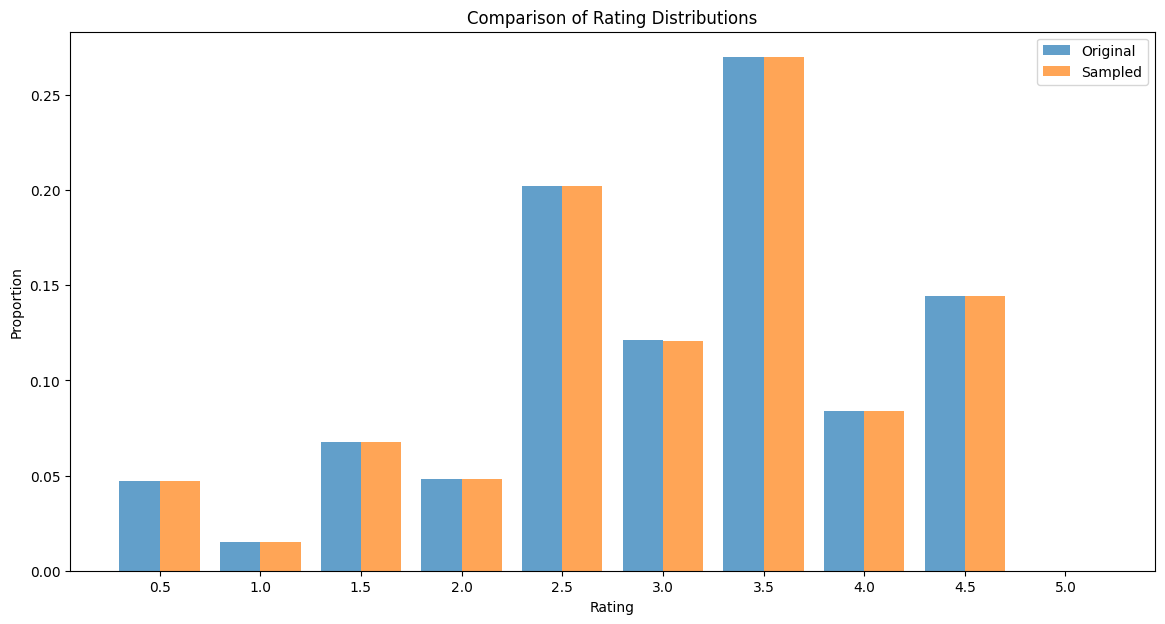

In [ ]:
# Define your bins
bins = np.arange(0.5, 6.0, 0.5)

# Calculate bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Define width of each bar
bar_width = 0.2

# Plot histograms
plt.figure(figsize=(14, 7))
plt.bar(bin_centers - bar_width/2, ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Original', align='center')
plt.bar(bin_centers + bar_width/2, strat_sampled_ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Sampled', align='center')

plt.title('Comparison of Rating Distributions')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(bin_centers, labels=[f"{bin:.1f}" for bin in bins[:-1]])  # Set x-tick labels to match bin centers
plt.legend()
plt.show()

In [ ]:
strat_sampled_ratings_df

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category
11800835,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)"
3192182,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)"
10041143,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)"
14911364,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)"
13024846,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)"
...,...,...,...,...,...,...,...
2596165,28184,2912,5.0,2000-11-21 00:08:40,3.588011,True,"[5.0, 5.5)"
2174721,23629,1185,5.0,1997-03-13 18:00:11,3.734463,True,"[5.0, 5.5)"
23363519,254448,49272,5.0,2016-08-08 15:59:55,3.819149,True,"[5.0, 5.5)"
19688576,214494,541,5.0,2005-04-05 14:26:59,3.395652,True,"[5.0, 5.5)"


The distribution of ratings in the downsampled dataset is similar to that of the original dataset, indicating that the stratified sampling process was successful. The downsampled dataset contains 100,000 entries and maintains the distribution of ratings across different categories.


We also did the Stratified Sampling for 1M and 3M datasets.

# 2 Content-Based-Recommendations

Content-based recommendation systems are an essential approach in the field of personalized recommendations. These systems generate suggestions that are closely aligned with user preferences by leveraging items' intrinsic attributes, such as movie descriptions, genres, cast, and metadata. Unlike collaborative filtering methods that rely on user interaction data, content-based recommendations can make relevant suggestions even for new items that do not have enough user reviews. This approach ensures more immediate and robust personalization, making it a critical strategy for providing accurate and meaningful movie recommendations.


In [ ]:
df_merged = pd.read_pickle('/content/drive/My Drive/ML Group/df_merged_cleaned.pkl')
df_ratings = pd.read_pickle('/content/drive/My Drive/ML Group/df_ratings_100k.pkl')

# 2.1 Preprocessing

### Inspecting the movies dataset regarding languages

Filtering df_merged to only include movies that are english. This ensures that the text data aligns with the language the model was trained on, which is crucial for the effectiveness of the embeddings generated by BERT.

In [ ]:
df_merged = df_merged[df_merged['original_language'] == 'en']

In [ ]:
df_merged

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,1,1,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America]
1,2,0,en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America]
2,3,1,en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America]
3,4,0,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America]
4,5,1,en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America]
...,...,...,...,...,...,...,...,...,...,...,...,...
46749,176263,0,en,It's the year 3000 AD. The world's most danger...,1995-01-01,85.0,Caged Heat 3000,"[Lisa Boyle, Kena Land, Zaneta Polard, Don Yan...",[(none)],[Science Fiction],[Concorde-New Horizons],[United States of America]
46750,176267,0,en,"Yet another version of the classic epic, with ...",1991-05-13,104.0,Robin Hood,"[Patrick Bergin, Uma Thurman, David Morrissey,...",[(none)],"[Drama, Action, Romance]","[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State..."
46753,176273,0,en,"When one of her hits goes wrong, a professiona...",2003-08-01,90.0,Betrayal,"[Erika Eleniak, Adam Baldwin, Julie du Page, J...",[(none)],"[Action, Drama, Thriller]",[American World Pictures],[United States of America]
46754,176275,0,en,"In a small town live two brothers, one a minis...",1917-10-21,87.0,Satan Triumphant,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",[(none)],[(none)],[Yermoliev],[Russia]


## 2.1.1 List Columns

To improve the quality of our dataset and prepare it for advanced text-based modeling, we will thoroughly clean four key columns: genre_extracted, actors, keywords_extracted, and production_company_extracted. This process entails standardizing the text by removing placeholders, lowercasing all entries, and filtering out non-alphabetical characters to ensure consistency across text fields.

### Inspection for placeholders

In [ ]:
placeholder_counts = df_merged['keywords_extracted'].apply(lambda x: str(x).strip().lower() == "['(none)']").value_counts()

print("Occurrences of '[(none)]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[(none)]': 7478
Occurrences of other values or variations: 22278


In [ ]:
placeholder_counts = df_merged['genre_extracted'].apply(lambda x: str(x).strip().lower() == "['(none)']").value_counts()

print("Occurrences of '[(none)]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[(none)]': 1110
Occurrences of other values or variations: 28646


In [ ]:
placeholder_counts = df_merged['production_company_extracted'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 7165
Occurrences of other values or variations: 22591


In [ ]:
placeholder_counts = df_merged['actors'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 1280
Occurrences of other values or variations: 28476


### Cleaning Function

The clean_list_data function is intended to clean lists by removing placeholder entries. It first determines whether the list is empty, and if not, it removes any of the placeholder entries. The function is then applied to several columns in the DataFrame df_merged, specifically the 'genre_extracted', 'actors', 'keywords_extracted', and 'production_company_extracted' columns, to ensure that they only contain meaningful data by removing any placeholder values.

In [ ]:
# Define a function to clean placeholders in lists
def clean_list_data(data):
    if not data:  # Checks if the list is empty
        return []
    # Remove any placeholder entries
    return [item for item in data if item.lower() not in ['(none)', 'none', 'n/a', 'null', 'unknown']]

# Apply the cleaning function to each column
df_merged['genre_extracted'] = df_merged['genre_extracted'].apply(clean_list_data)
df_merged['actors'] = df_merged['actors'].apply(clean_list_data)
df_merged['keywords_extracted'] = df_merged['keywords_extracted'].apply(clean_list_data)
df_merged['production_company_extracted'] = df_merged['production_company_extracted'].apply(clean_list_data)

### Verification of cleaning

In [ ]:
placeholder_counts = df_merged['keywords_extracted'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 7478
Occurrences of other values or variations: 22278


In [ ]:
placeholder_counts = df_merged['genre_extracted'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 1110
Occurrences of other values or variations: 28646


In [ ]:
placeholder_counts = df_merged['production_company_extracted'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 7165
Occurrences of other values or variations: 22591


In [ ]:
placeholder_counts = df_merged['actors'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 1280
Occurrences of other values or variations: 28476


After applying the cleaning function to the 'genre_extracted', 'actors', 'keywords_extracted', and 'production_company_extracted' columns in the DataFrame df_merged, placeholders have successfully been standardized to [] for the inspected columns.

### Standardize Case and Remove Special Characters

This is essential to maintain consistency and reduce the vocabulary size that the model needs to understand.

In [ ]:
# Function to clean individual strings in lists
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    return text.strip()

# Function to process lists of strings
def preprocess_list(data):
    return [clean_text(item) for item in data if item]

In [ ]:
# Apply preprocessing to each column
df_merged['genre_extracted'] = df_merged['genre_extracted'].apply(preprocess_list)
df_merged['actors'] = df_merged['actors'].apply(preprocess_list)
df_merged['keywords_extracted'] = df_merged['keywords_extracted'].apply(preprocess_list)
df_merged['production_company_extracted'] = df_merged['production_company_extracted'].apply(preprocess_list)

## 2.1.2 'Overview' Column

In the following sections, we will thoroughly analyze and clean the "Overview" column, which contains detailed descriptions of movies that are critical to generate meaningful content-based recommendations

In [ ]:
df_merged["overview"].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [ ]:
# Number of total values
total_entries = len(df_merged['overview'])
print(f"Total entries: {total_entries}")

# Number of missing values
missing_values = df_merged['overview'].isnull().sum()
print(f"Missing values: {missing_values}")

# Number of unique values
unique_values = df_merged['overview'].nunique()
print(f"Unique values: {unique_values}")

# Average length of movie descriptions
average_length = df_merged['overview'].dropna().apply(len).mean()
print(f"Average Length of Descriptions: {average_length:.2f} characters")

# Shortest length of movie descriptions
shortest_length = df_merged['overview'].dropna().apply(len).min()
print(f"Shortest Length of Descriptions: {shortest_length:.2f} characters")

# Longest length of movie descriptions
longest_length = df_merged['overview'].dropna().apply(len).max()
print(f"Longest Length of Descriptions: {longest_length:.2f} characters")

Total entries: 29756
Missing values: 0
Unique values: 29690
Average Length of Descriptions: 313.33 characters
Shortest Length of Descriptions: 1.00 characters
Longest Length of Descriptions: 1000.00 characters


After examining the entries in the df_merged DataFrame with 1000-character descriptions, We are decided to keep them. These descriptions are complete and informative, despite reaching the character limit. They are fully usable and add value to our analysis. Consequently, we will continue to include these long descriptions to ensure the dataset remains robust and comprehensive.

Identify entries where descriptions are extremely short. These might be errors or insufficient descriptions.

In [ ]:
short_descriptions_mask = df_merged['overview'].dropna().apply(len) < 30

# Filter the original DataFrame to show only rows with short descriptions
short_desc_df = df_merged[short_descriptions_mask]

# Display these descriptions to assess their relevance
short_desc_df.head(10)

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
987,1001,0,en,No overview found.,1979-08-22,94.0,L'associé,"[michel serrault, claudine auger, catherine al...",[],[comedy],[],[]
1633,1692,0,en,No overview found.,1996-01-01,85.0,Alien Escape,"[gail harris, bernie van de yacht, heather for...","[female nudity, mutant, cabin, alien lifeform,...","[horror, science fiction]",[],[United States of America]
2250,2343,0,en,No overview found.,1998-08-02,98.0,The Naked Man,"[michael rapaport, michael jeter, rachael leig...","[male nudity, double life, wrestling, murder, ...","[comedy, thriller]",[],[United States of America]
3788,3887,0,en,No overview found.,1998-01-01,94.0,Went to Coney Island on a Mission from God... ...,[],[independent film],[drama],[],[]
4573,4667,0,en,,1989-03-18,124.0,Slaves of New York,"[bernadette peters, chris sarandon, mary beth ...",[],[drama],[],[United States of America]
7382,7566,1,en,No overview found.,1984-11-20,136.0,28 Up,[],[],"[documentary, foreign]",[],[United Kingdom]
9262,27215,0,en,No overview found.,2000-08-18,103.0,Badding,"[janne reinikainen, karoliina blackburn, peter...",[],[],[],[Finland]
9986,32659,0,en,No overview found.,2001-11-21,108.0,Tanguy,"[eric berger, sabine azma, andr dussollier, hl...","[paris, china, parent child relationship, flat...",[comedy],"[les productions du champ poirier, tps cinma, ...",[France]
11371,48167,0,en,No overview found.,2004-01-29,92.0,Aaltra,"[benot delpine, gustave de kervern, michel de ...","[belgium, wheelchair user, lovehate relationsh...","[comedy, foreign, drama]",[la parti productions],[France]
11679,51014,0,en,No overview found.,1968-01-07,120.0,The Strange Case of Dr. Jekyll and Mr. Hyde,"[jack palance, denholm elliott, leo genn, tori...","[london england, double life, jekyll and hyde]","[drama, science fiction, thriller]",[],"[Canada, United States of America]"


Identified entries: No overview found, blank, ..., Not Available, No Overview, x, no overview yet,

In [ ]:
# Create a list with unwanted movie descriptions
unwanted_strings = ['No overview found.', '', '...', 'Not Available', 'No Overview', 'x', 'no overview yet', "No overview"]

# Strip leading and trailing spaces and filter out rows with unwanted strings and ensure length is at least 10 characters
df_merged['overview'] = df_merged['overview'].str.strip()
df_merged = df_merged[~df_merged['overview'].isin(unwanted_strings) & (df_merged['overview'] != '') & (df_merged['overview'].str.len() >= 10)]

# Check the updated DataFrame
print("Total entries after cleaning:", df_merged.shape[0])

Total entries after cleaning: 29697


In [ ]:
# Find duplicates in the 'overview' column
duplicates = df_merged['overview'].duplicated(keep=False)

# Filter the DataFrame to show only the duplicated overviews
duplicated_overviews = df_merged[duplicates]

# Display the head of the duplicated overviews
print(duplicated_overviews[['overview', "release_date"]].head(10))

                                                overview release_date
2048   Wilbur the pig is scared of the end of the sea...   1973-03-01
2397   With friends like these, who needs enemies? Th...   1999-02-05
2985   Director Michael Apted revisits the same group...   1998-07-28
4705   Adventurer Allan Quartermain leads an expediti...   1937-01-01
7080   Nick Carraway, a young Midwesterner now living...   1974-03-27
8537   Adventurer Allan Quartermain leads an expediti...   1950-11-09
9024   Director Michael Apted revisits the same group...   1991-08-29
11539  Wilbur the pig is scared of the end of the sea...   2006-12-15
14547  Miser Ebenezer Scrooge is awakened on Christma...   2009-11-04
16855  Mary, a writer working on a novel about a love...   1941-08-29


Duplicates are due to the fact that movies of the same series are featured in the dataset.

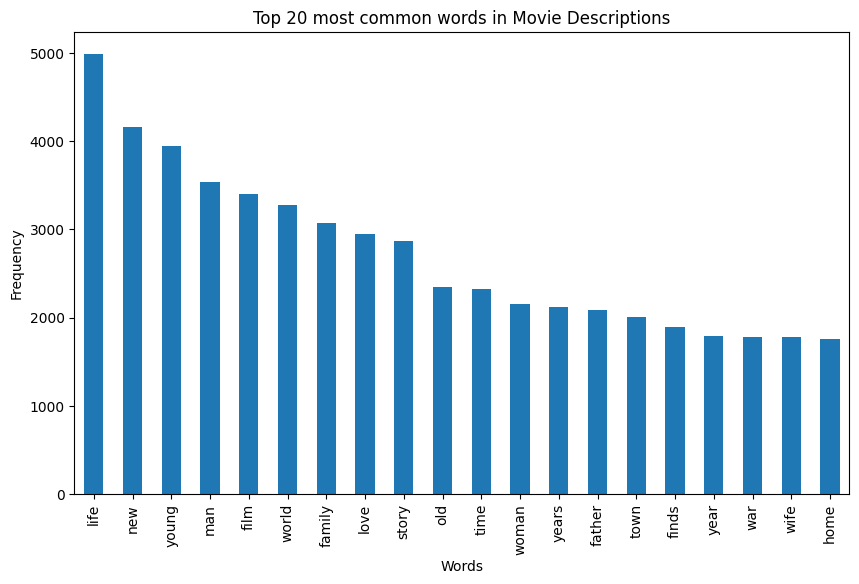

In [ ]:
# Create a vectorizer instance to count frequencies
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_merged['overview'].dropna())

# Convert X to a DataFrame
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts.sum().sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 6))
common_words.plot(kind='bar')
plt.title('Top 20 most common words in Movie Descriptions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

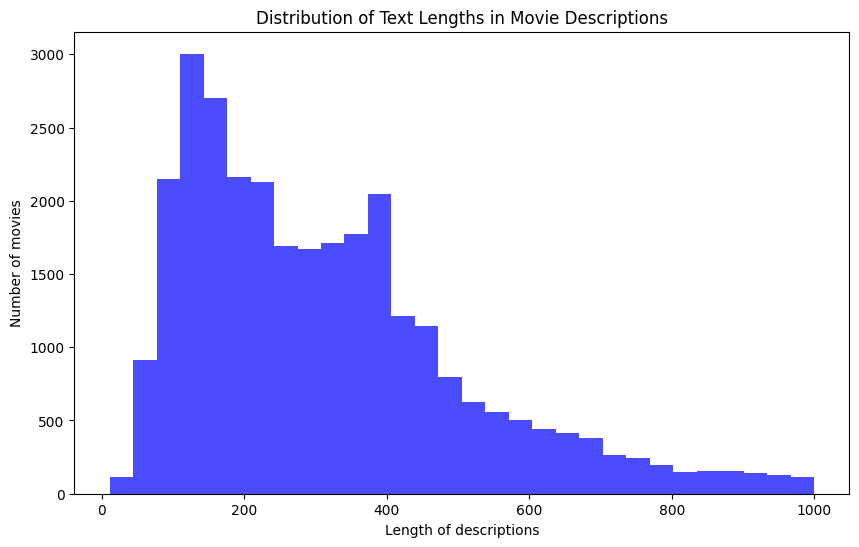

In [ ]:
# Calculate text lengths
text_lengths = df_merged['overview'].dropna().apply(len)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths in Movie Descriptions')
plt.xlabel('Length of descriptions')
plt.ylabel('Number of movies')
plt.show()

Interpretation
- From the graph, it's evident that the distribution is right-skewed, with a majority of descriptions being between roughly 100 and 400 characters long. There are fewer very short descriptions (near 0 characters) and the number of descriptions decreases steadily as the length increases, with very few descriptions reaching up to 1000 characters.
- Significant number of between 100-300 Characters: Most descriptions are concise, providing brief information about the movie, which is typical for summaries intended to give a quick overview without going into detail.
- Few Long Descriptions: The sharp decline in frequency as description length increases suggests that longer descriptions are uncommon. These might be detailed synopses rather than simple overviews.
- Very Short Descriptions: The relatively low number of extremely short descriptions (near 0 characters) is good as these might not provide useful information.

Considerations for NLP Recommender System based on Similarity Score

- The prevalence of shorter texts facilitates standardized embedding processes, reducing the complexity of handling variable text lengths. Descriptions within the 100-300 character range provide enough detail for effective similarity analysis, allowing accurate recommendations based on narrative elements.
- Vector Representation of Texts:
Texts need to be converted into numerical representations (e.g., TF-IDF or Word2Vec embeddings) for similarity comparison. The effectiveness of these representations can vary with text length.
Short descriptions may not provide enough context for accurate similarity scoring, while very long descriptions might introduce too much noise or irrelevant information.
- We'll continuously refine our handling of text lengths based on system performance to balance detail richness with computational demands.

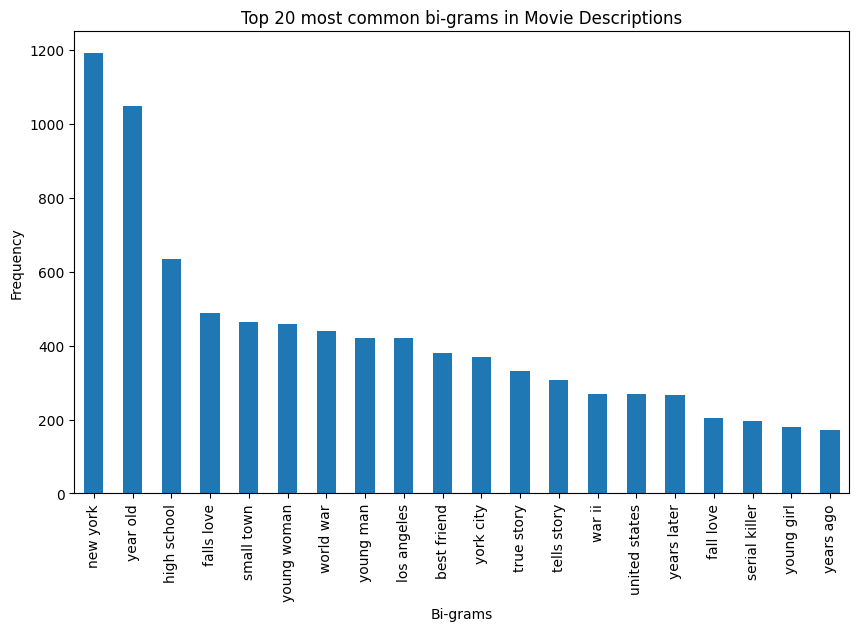

In [ ]:
# Bi-grams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigram_matrix = bigram_vectorizer.fit_transform(df_merged['overview'].dropna())

# Sum up the counts of each bi-gram and sort
bigrams = pd.DataFrame(bigram_matrix.toarray(), columns=bigram_vectorizer.get_feature_names_out())
common_bigrams = bigrams.sum().sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 6))
common_bigrams.plot(kind='bar')
plt.title('Top 20 most common bi-grams in Movie Descriptions')
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Potentially checking for and removing noise like HTML tags, excessive symbols, etc.
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    return text

# Apply cleaning function
cleaned_overviews = df_merged['overview'].apply(clean_text)

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29697 entries, 0 to 46755
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   movieId                       29697 non-null  Int64         
 1   belongs_to_collection         29697 non-null  int64         
 2   original_language             29697 non-null  object        
 3   overview                      29697 non-null  object        
 4   release_date                  29697 non-null  datetime64[ns]
 5   runtime                       29697 non-null  float64       
 6   title                         29697 non-null  object        
 7   actors                        29697 non-null  object        
 8   keywords_extracted            29697 non-null  object        
 9   genre_extracted               29697 non-null  object        
 10  production_company_extracted  29697 non-null  object        
 11  production_country_extracted  296

Define the clean_text function to standardize the movie descriptions by converting all text to lowercase, removing HTML tags and special characters. Finally apply this function to the 'overview' column of my df_merged DataFrame to prepare the data for further analysis.

In [ ]:
def clean_text(text):
    if not pd.isna(text):
        # Convert text to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    return text

In [ ]:
# Apply the cleaning function to the 'overview' column
df_merged['overview'] = df_merged['overview'].apply(clean_text)

##Inspect the column

In [ ]:
pd.set_option('display.max_colwidth', None)
df_merged["overview"].head(10)

0                                                                                                                                                   led by woody andys toys live happily in his room until andys birthday brings buzz lightyear onto the scene afraid of losing his place in andys heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences
1                                                           when siblings judy and peter discover an enchanted board game that opens the door to a magical world they unwittingly invite alan  an adult whos been trapped inside the game for  years  into their living room alans only hope for freedom is to finish the game which proves risky as all three find themselves running from giant rhinoceroses evil monkeys and other terrifying creatures
2                                                                                                                 

In [ ]:
# Inspect any row of the overview column
print(df_merged['overview'].iloc[[10, 50, 100]])

10                                                                                                                                                 widowed us president andrew shepherd one of the worlds most powerful men can have anything he wants  and what he covets most is sydney ellen wade a washington lobbyist but shepherds attempts at courting her spark wild rumors and decimate his approval ratings
54     sadie looks up to her older sister georgia a successful folk singer whos happily married with children but cant break out of the barband circuit and hit the big time she desperately covets its in part due to her attraction to drugs and booze and also to her own unwise choice in men finally though sadies achilles heel is a rough unlovely voice very different than her sisters crowdpleasing singing
113                                    francis the boss of a small plumbing supply company is harassed by tax collectors striking employees and an impossible wife and daughter his only joy

# 2.2 Feature Engineering

Next, we focus on the critical task of feature engineering, which involves transforming raw data into meaningful features that improve the performance of our content-based recommendation models. We hope to capture the movies' essential characteristics by carefully selecting and creating features such as 'combined_text'. These engineered features serve as the foundation for developing robust recommender systems.

### Textual Feature - Combined Text

After thoughtfully cleaning the different text columns of the dataset that might be relevant to give content-based reocmmendations we want to combine them into a single feature column. The combined_text feature aggregates critical textual metadata from genres, actors, keywords, and movie descriptions into a single comprehensive descriptor for each movie. This aggregation captures the essence of a movie’s content, thematic elements, and appeal, which is crucial for content-based filtering. By synthesizing this information, the recommender system can identify and suggest movies with similar thematic and content attributes, enhancing personalization and user engagement.

In [ ]:
# Define a function to join non-empty items
def join_non_empty(items):
    # Filter out empty lists and join non-empty strings with a space
    return ' '.join([item for item in items if item])

# Apply the function to each row in df_merged to create the combined_text column
df_merged['combined_text'] = df_merged.apply(lambda row: join_non_empty([
    ' '.join(row['genre_extracted']),
    ' '.join(row['actors']),
    ' '.join(row['keywords_extracted']),
    ' '.join(row['production_company_extracted']),
    row['overview']
]), axis=1)

### Weighted Score

The weighted_score feature adds a movie's average rating to the number of ratings it has received, ensuring that movies with a large number of ratings are given appropriate weight. This score reduces the bias toward movies with fewer ratings, which may have artificially high scores. The weighted_score is a more balanced and reliable measure of a film's popularity and quality because it takes into account both the quality and quantity of ratings. This feature is useful for advanced content-based modeling because it improves the accuracy and robustness of recommendations by prioritizing highly rated and frequently rated movies, resulting in more trustworthy and relevant suggestions for users.

In [ ]:
movie_stats = df_ratings.groupby('movieId').agg(average_rating=('rating', 'mean'), rating_count=('rating', 'count')).reset_index()

C = movie_stats['average_rating'].mean()
m = movie_stats['rating_count'].quantile(0.90)

def weighted_rating(x, m=m, C=C):
    v = x['rating_count']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

movie_stats['weighted_score'] = movie_stats.apply(weighted_rating, axis=1)

df_ratings = df_ratings.merge(movie_stats[['movieId', 'weighted_score']], on='movieId', how='left')

df_ratings = df_ratings.merge(movie_stats[['movieId', 'average_rating', 'rating_count']], on='movieId', how='left')

print(df_ratings.head())

   userId  movieId  rating           timestamp  user_mean_rating  \
0  128365     1037     0.5 2009-10-19 10:10:37          3.104895   
1   34770    27316     0.5 2006-06-10 09:14:33          1.329146   
2  108700      307     0.5 2010-05-12 21:26:12          3.729651   
3  162680    73929     0.5 2015-11-22 18:22:29          3.505618   
4  141941     4308     0.5 2006-06-10 05:21:47          2.987685   

   liked_by_user rating_category  weighted_score  average_rating  rating_count  
0          False      [0.5, 1.0)        2.987271            2.75            32  
1          False      [0.5, 1.0)        3.205775            2.25             2  
2          False      [0.5, 1.0)        3.593367            3.92            25  
3          False      [0.5, 1.0)        3.176359             0.5             1  
4          False      [0.5, 1.0)        3.444903        3.516667            60  


### Movie Age

The movie_age feature calculates the number of years since a movie's release by subtracting the current year from the release year. This feature is important for advanced content-based modeling because it allows the recommender system to consider a movie's age, which can influence user preferences. Incorporating movie_age allows the model to distinguish between classic films and new releases, allowing it to make more nuanced and personalized recommendations by taking into account how users' interests may differ depending on the age of the films.

In [ ]:
current_year = datetime.datetime.now().year

df_merged['movie_age'] = current_year - pd.to_datetime(df_merged['release_date']).dt.year

### Sentiment Analysis Overview

The sentiment_polarity feature represents the sentiment score of a movie overview, which is calculated using the TextBlob library to determine the polarity of the text. This feature is useful for advanced content-based modeling because it quantifies the emotional tone of a movie's description, providing information about whether it is perceived as positive, negative, or neutral. By incorporating sentiment_polarity, the recommender system can better align recommendations with users' emotional preferences and sentiments, increasing the relevancy and personalization of suggestions.


In [ ]:
def get_sentiment(text):
    try:
        return float(TextBlob(text).sentiment.polarity)
    except Exception as e:
        print(f"Error processing text: {e}")
        return float('nan')

df_merged['sentiment_polarity'] = df_merged['overview'].apply(get_sentiment)

In [ ]:
print("Number of NaN values in 'sentiment_polarity' after conversion:", df_merged['sentiment_polarity'].isna().sum())

Number of NaN values in 'sentiment_polarity' after conversion: 0


Adding engineered features to df_grouped

 #### Combining df_ratings and df_merged

In [ ]:
df_combined = pd.merge(df_ratings, df_merged, on='movieId', how='inner')

#### Rating Threshold

Setting a rating threshold of 20 ensures that only movies with a large number of ratings are included in the dataset for modeling. This makes sense because movies with few ratings may have unreliable or skewed average ratings, reducing the accuracy of the recommendation system. By excluding movies with fewer than 20 ratings, the model focuses on films with more consistent and representative user feedback, resulting in more reliable and robust recommendations. This threshold helps to maintain the dataset's quality and reliability, which improves the overall performance of content-based modeling.

In [ ]:
ratings_per_movie = df_combined.groupby('movieId').size()

movies_with_enough_ratings = ratings_per_movie[ratings_per_movie >= 20].index

df_item_modeling = df_combined[df_combined['movieId'].isin(movies_with_enough_ratings)]

print(f"Original dataset size: {df_combined.shape}")
print(f"Filtered dataset size: {df_item_modeling.shape}")

Original dataset size: (93810, 24)
Filtered dataset size: (65766, 24)


#### Grouping Movies

We are configuring the modeling DataFrame, df_grouped, which contains the engineered features. This DataFrame aggregates data by movieId, keeping the first occurrence of the title and combined text and calculating the mean values for weighted_score, movie_age, and sentiment_polarity. This aggregation ensures that each movie is represented by its key features, allowing for advanced content-based modeling.

In [ ]:
df_grouped = df_item_modeling.groupby('movieId', as_index=False).agg({
    'title': 'first',
    'combined_text': 'first',
    'weighted_score': 'mean',
    'movie_age': 'mean',
    'sentiment_polarity': 'mean'
})

df_grouped.head()

,movieId,title,combined_text,weighted_score,movie_age,sentiment_polarity
0,1,Toy Story,animation comedy family tom hanks tim allen don rickles jim varney wallace shawn john ratzenberger annie potts john morris erik von detten laurie metcalf r lee ermey sarah freeman penn jillette jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life pixar animation studios led by woody andys toys live happily in his room until andys birthday brings buzz lightyear onto the scene afraid of losing his place in andys heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences,3.808411,29.0,0.112121
1,2,Jumanji,adventure fantasy family robin williams jonathan hyde kirsten dunst bradley pierce bonnie hunt bebe neuwirth david alan grier patricia clarkson adam hannbyrd laura bell bundy james handy gillian barber brandon obray cyrus thiedeke gary joseph thorup leonard zola lloyd berry malcolm stewart annabel kershaw darryl henriques robyn driscoll peter bryant sarah gilson florica vlad june lion brenda lockmuller board game disappearance based on childrens book new home recluse giant insect tristar pictures teitler film interscope communications when siblings judy and peter discover an enchanted board game that opens the door to a magical world they unwittingly invite alan an adult whos been trapped inside the game for years into their living room alans only hope for freedom is to finish the game which proves risky as all three find themselves running from giant rhinoceroses evil monkeys and other terrifying creatures,3.299728,29.0,-0.218750
2,3,Grumpier Old Men,romance comedy walter matthau jack lemmon annmargret sophia loren daryl hannah burgess meredith kevin pollak fishing best friend duringcreditsstinger old men warner bros lancaster gate a family wedding reignites the ancient feud between nextdoor neighbors and fishing buddies john and max meanwhile a sultry italian divorce opens a restaurant at the local bait shop alarming the locals who worry shell scare the fish away but shes less interested in seafood than she is in cooking up a hot time with max,3.289113,29.0,0.038889
3,5,Father of the Bride Part II,comedy steve martin diane keaton martin short kimberly williamspaisley george newbern kieran culkin bd wong peter michael goetz kate mcgregorstewart jane adams eugene levy lori alan baby midlife crisis confidence aging daughter mother daughter relationship pregnancy contraception gynecologist sandollar productions touchstone pictures just when george banks has recovered from his daughters wedding he receives the news that shes pregnant and that georges wife nina is expecting too he was planning on selling their home but thats a plan that like george will have to change with the arrival of both a grandchild and a kid of his own,3.208483,29.0,0.466667
4,6,Heat,action crime drama thriller al pacino robert de niro val kilmer jon voight tom sizemore diane venora amy brenneman ashley judd mykelti williamson natalie portman ted levine tom noonan tone loc hank azaria wes studi dennis haysbert danny trejo henry rollins william fichtner kevin gage susan traylor jerry trimble ricky harris jeremy piven xander berkeley begonya plaza rick avery hazelle goodman ray buktenica max daniels vince deadrick jr steven ford farrah forke patricia healy paul herman cindy katz brian libby dan martin mario roberts thomas rosales jr yvonne zima mick gould bud cort viviane vives kim staunton martin ferrero brad baldridge andrew camuccio kenny endoso kimberly flynn niki harris bill mcintosh rick marzan terry miller daniel ohaco kai soremekun peter blackwell trevor coppola mary kircher darin mangan robert miranda manny perry iva franks singer tim werner philip ettington robbery detective bank obsession chase shooting thief honor murder suspense heist betrayal money gang cat and mouse criminal mastermind cult film excon heist movie one last job loner bank jo

# 2.3 Modeling

In this section, we will configure and test various content-based recommender systems using advanced techniques. These include TFIDF for term frequency analysis, Word2Vec for capturing semantic relationships between words, and BERT Foundation Models for deep contextual understanding. Each technique will feature both baseline and advanced models. The baseline models will only consider cosine similarity to establish a benchmark for each technique, whereas the advanced models will include additional features to improve the relevance of our movie recommendations, leveraging the engineered features we have prepared.


## 2.3.1 TFIDF Content Recommendations

To start off, we will use TFIDF (Term Frequency-Inverse Document Frequency) analysis to build content-based recommendation systems. This technique, which assesses the importance of words in documents in comparison to a collection of documents, was previously used in the part 1 of the project. We will summarize it here to establish a performance benchmark for future comparison with new models. TFIDF allows us to recommend similar movies based on textual content because it captures the relevance of terms within movie descriptions. We will create both baseline and advanced models, with the baseline model using cosine similarity to benchmark the technique and the advanced model adding additional features to improve recommendation relevance capturing more complex relationships and nuances within the data.







### TFIDF Baseline Model

In [ ]:
class BaselineContentRecommenderTFIDF:
    def __init__(self, movies_df, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(df_grouped['combined_text'])
        self.similarity_matrix = cosine_similarity(self.tfidf_matrix)

    def recommend(self, movie_id, top_n=10):
        movie_id = str(movie_id)
        if movie_id not in self.movie_id_to_index:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return []

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]
        recommendations = self.movies_df.iloc[top_k_indices].copy()
        recommendations['cosine_similarity'] = similarity_scores[top_k_indices]

        return recommendations.sort_values('cosine_similarity', ascending=False)

In [ ]:
recommender_baseTFIDF = BaselineContentRecommenderTFIDF(df_grouped, k=100)
recommendations_baseTFIDF = recommender_baseTFIDF.recommend('1', top_n=10)
print(recommendations_baseTFIDF[['movieId', 'title', 'cosine_similarity']])

     movieId                       title  cosine_similarity
720     3114                 Toy Story 2           0.457090
1147   78499                 Toy Story 3           0.381763
28        60  The Indian in the Cupboard           0.113025
674     2797                         Big           0.108510
307     1103       Rebel Without a Cause           0.107731
887     4886              Monsters, Inc.           0.098461
199      596                   Pinocchio           0.094334
1130   68954                          Up           0.087531
591     2355                A Bug's Life           0.084093
1176   95441                         Ted           0.082772


In [ ]:
recommendations_baseTFIDF = recommender_baseTFIDF.recommend('2', top_n=10)
print(recommendations_baseTFIDF[['movieId', 'title', 'cosine_similarity']])

     movieId                                                           title  \
637     2600                                                        eXistenZ   
561     2161                                           The NeverEnding Story   
905     5266                                                      Panic Room   
546     2105                                                            Tron   
1180   97913                                                  Wreck-It Ralph   
1048   41566  The Chronicles of Narnia: The Lion, the Witch and the Wardrobe   
1075   49272                                                   Casino Royale   
719     3108                                                 The Fisher King   
1009    8957                                                             Saw   
791     3698                                                 The Running Man   

      cosine_similarity  
637            0.122969  
561            0.108911  
905            0.102681  
546            

### TFIDF Advanced Model

We will now include additional features for the advanced model. These features are weighted_score, sentiment_polarity, and movie_age, and they will be combined with the cosine similarity score to improve the overall recommendation.

In [ ]:
class AdvancedContentRecommenderTFIDF:
    def __init__(self, movies_df, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.k = k
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.movies_df['combined_text'])
        self.similarity_matrix = cosine_similarity(self.tfidf_matrix)

    def recommend(self, movie_id, top_n=10):
        movie_id = str(movie_id)
        if movie_id not in self.movies_df['movieId'].values:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return pd.DataFrame()

        movie_index = self.movies_df.index[self.movies_df['movieId'] == movie_id].tolist()[0]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        top_k_df = self.movies_df.iloc[top_k_indices].copy()

        scaler = MinMaxScaler()
        for feature in ['weighted_score', 'movie_age']:
            if feature in top_k_df:
                top_k_df[feature] = scaler.fit_transform(top_k_df[[feature]].values.reshape(-1, 1))

        top_k_df['cosine_similarity'] = similarity_scores[top_k_indices]
        top_k_df['combined_score'] = (
            0.5 * top_k_df['cosine_similarity'] +
            0.2 * top_k_df['weighted_score'] +
            0.3 * top_k_df['sentiment_polarity'] +
            0.1 * top_k_df['movie_age']
        )

        return top_k_df.nlargest(top_n, 'combined_score')[['movieId', 'title', 'combined_score']]

In [ ]:
recommender_advanced_tfidf = AdvancedContentRecommenderTFIDF(df_grouped, k=100)
recommendations_advanced_tfidf = recommender_advanced_tfidf.recommend('1', top_n=10)
print(recommendations_advanced_tfidf[['movieId', 'title', 'combined_score']])

     movieId              title  combined_score
720     3114        Toy Story 2        0.494856
343     1235   Harold and Maude        0.348563
538     2078    The Jungle Book        0.322128
591     2355       A Bug's Life        0.318722
276     1028       Mary Poppins        0.310332
340     1230         Annie Hall        0.308001
527     2018              Bambi        0.302490
1147   78499        Toy Story 3        0.296122
1005    8910  I Heart Huckabees        0.292712
346     1244          Manhattan        0.292305


## 2.3.2 Word2Vec Content Recommendations

In this section, we'll use Word2Vec, a neural network-based technique that converts words' semantic relationships into continuous vector representations, to build content-based recommender systems. This method enables us to comprehend and represent the contextual meaning of words in movie descriptions, allowing for more sophisticated and meaningful comparisons between films.

### Importing Google Word2Vec Model

We are choosing to import Google's pre-trained Word2Vec model primarily because of its extensive training on a large Google News dataset, which includes a rich and diverse vocabulary from multiple domains, ensuring comprehensive coverage and nuanced understanding of language. This model, which has already been trained, saves significant time and computational resources that would otherwise be required to train a model from scratch. It provides high-quality word embeddings that capture complex semantic relationships between words, allowing for the creation of more advanced, contextually aware recommendation systems. Furthermore, the pre-trained model has the potential to improve generalization capabilities across various textual data, increasing the accuracy and relevance of recommendations without the need for extensive domain-specific data for training. This makes it an effective choice for quickly integrating advanced NLP features into applications, particularly when working with limited resources like we are during this project.

In [ ]:
"""
import gensim.downloader as api

# Load the model
word2vec_model = api.load('word2vec-google-news-300')

# Save the model to Drive
word2vec_model.save('/content/drive/My Drive/ML Group/word2vec-google-news-300.model')
"""


"\nimport gensim.downloader as api\n\n# Load the model\nword2vec_model = api.load('word2vec-google-news-300')\n\n# Save the model to Drive\nword2vec_model.save('/content/drive/My Drive/ML Group/word2vec-google-news-300.model')\n"

In [ ]:
# Load the model from Google Drive
word2vec_model = KeyedVectors.load('/content/drive/My Drive/ML Group/word2vec-google-news-300.model', mmap='r')

### Baseline Word2Vec

The Baseline Word2Vec model sets a performance benchmark by focusing solely on the cosine similarity of movie descriptions. Using the Word2Vec model to convert textual data into continuous vector representations, semantic relationships between words are captured. This method allows us to compare the similarity of movies based on their textual features, providing a fundamental benchmark for evaluating more sophisticated models.

In [ ]:
class BaselineContentRecommenderWord2Vec:
    def __init__(self, movies_df, word2vec_model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Calculate Word2Vec vectors for the processed_text and store them in the dataframe
        self.movies_df['word2vec_vector'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(word2vec_model, doc))

        # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['word2vec_vector'])

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, model, doc):
        # Tokenize the document and take the average of the word vectors
        words = doc.split()
        valid_words = [word for word in words if word in model.key_to_index]
        if valid_words:
            return np.mean(model[valid_words], axis=0)
        else:
            return np.zeros(model.vector_size)

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return []

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        recommendations = self.movies_df.iloc[top_k_indices].copy()
        recommendations['cosine_similarity'] = similarity_scores[top_k_indices]

        return recommendations.sort_values('cosine_similarity', ascending=False)

In [ ]:
recommender_base_word2vec = BaselineContentRecommenderWord2Vec(df_grouped, word2vec_model)
recommendations_base_word2vec = recommender_base_word2vec.recommend('1', top_n=10)
print(recommendations_base_word2vec[['movieId', 'title', 'cosine_similarity']])

     movieId                 title  cosine_similarity
720     3114           Toy Story 2           0.916175
1133   69757  (500) Days of Summer           0.904147
49       158                Casper           0.903566
406     1380                Grease           0.902637
674     2797                   Big           0.902566
...      ...                   ...                ...
1180   97913        Wreck-It Ralph           0.875085
263      933      To Catch a Thief           0.874960
250      909         The Apartment           0.874792
305     1100       Days of Thunder           0.874344
625     2490               Payback           0.874319

[100 rows x 3 columns]


### Advanced Word2Vec

Similar to the logic used in the TFIDF advanced model, the Advanced Word2Vec model includes additional features to improve recommendation relevance. In addition to cosine similarity between Word2Vec embeddings, this model incorporates key features such as weighted_score, sentiment_polarity, and movie_age. By combining these factors, the Advanced Word2Vec method captures more complex relationships and nuances, resulting in more sophisticated movie recommendations.

In [ ]:
class AdvancedContentRecommenderWord2Vec:
    def __init__(self, movies_df, word2vec_model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Calculate Word2Vec vectors for the processed_text and store them in the dataframe
        self.movies_df['word2vec_vector'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(word2vec_model, doc))

         # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['word2vec_vector'])

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, model, doc):
        words = doc.split()
        valid_words = [word for word in words if word in model.key_to_index]
        if valid_words:
            return np.mean(model[valid_words], axis=0)
        else:
            return np.zeros(model.vector_size)

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
          print(f"Movie ID {movie_id} not found in the dataset.")
          return pd.DataFrame()

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        top_k_df = self.movies_df.iloc[top_k_indices].copy()

        # Apply dynamic scaling to the features within the context of the top_k recommendations
        scaler = MinMaxScaler()
        for feature in ['weighted_score', 'movie_age']:
            if feature in top_k_df:
                top_k_df[feature] = scaler.fit_transform(top_k_df[[feature]].values.reshape(-1, 1))

        top_k_df['cosine_similarity'] = similarity_scores[top_k_indices]
        top_k_df['combined_score'] = (
          0.5 * top_k_df['cosine_similarity'] +
          0.2 * top_k_df['weighted_score'] +
          0.2 * top_k_df['sentiment_polarity'] +
          0.1 * top_k_df['movie_age']
        )

        return top_k_df.nlargest(top_n, 'combined_score')[['movieId', 'title', 'combined_score', 'cosine_similarity']]

In [ ]:
recommender_advanced_word2vec = AdvancedContentRecommenderWord2Vec(df_grouped, word2vec_model)
recommendations_advanced_word2vec = recommender_advanced_word2vec.recommend('1', top_n=10)
print(recommendations_advanced_word2vec[['movieId', 'title', 'combined_score']])

    movieId                                title  combined_score
813    3911                         Best in Show        0.727264
276    1028                         Mary Poppins        0.709346
248     905                It Happened One Night        0.707435
542    2087                            Peter Pan        0.695356
720    3114                          Toy Story 2        0.690020
245     902               Breakfast at Tiffany's        0.675651
364    1269                 Arsenic and Old Lace        0.674261
290    1073  Willy Wonka & the Chocolate Factory        0.670177
250     909                        The Apartment        0.669026
326    1207                To Kill a Mockingbird        0.660063


## 2.3.3 BERT-Based Content Recommendations



This section will show how to build content-based recommender systems with BERT (Bidirectional Encoder Representations from Transformers) models. BERT models provide deep contextual understanding by capturing the nuances of word relationships in the text. Using BERT, we hope to generate high-quality embeddings that reflect the semantic content of movie descriptions. These models are very large pretrained models built on the transformer architecture and are well-known for their superior performance in natural language understanding tasks. The BERT model family includes a number of variants that have been fine-tuned for specific natural language processing tasks, providing tailored solutions for a variety of applications.


Therefore selecting an appropriate model that fits the usecase of generating content recommendations leveraging cosine similarity based on text embeddings is crucial to ensure accurate and meaningful results. In this context, models from the BERT family, particularly those fine-tuned for sentence embeddings, stand out due to their robust performance in capturing semantic similarities. After conducting research we are choosing the all-mpnet-base-v2 model from the Sentence-Transformers library for our content recommender system. This model is designed to generate high-quality embeddings that encapsulate the nuanced meanings and relationships within the text. By leveraging all-mpnet-base-v2, we can effectively compute cosine similarity between item descriptions, leading to more precise and relevant content-based recommendations. This choice is driven by the model's proven ability to understand and represent complex language structures, making it an excellent fit for identifying similar items based on their textual content.

In [ ]:
# Load Sentence-BERT model
model_name = 'all-mpnet-base-v2'
bert_model = SentenceTransformer(model_name)

### Base BERT

The Base BERT model sets a standard for text embeddings by using the pretrained BERT model to create embeddings for movie descriptions. This baseline approach, which focuses on cosine similarity, evaluates the effectiveness of BERT's deep contextual embeddings in capturing the semantic content of text, providing a fundamental comparison point for more sophisticated models.

In [ ]:
class BaselineContentRecommenderBERT:
    def __init__(self, movies_df, model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Use the preloaded Sentence-BERT model
        self.model = model

        # Calculate Sentence-BERT embeddings for the combined_text and store them in the dataframe
        self.movies_df['sbert_embedding'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(doc))

        # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['sbert_embedding'].values)

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, doc):
        # Encode the document using Sentence-BERT
        embedding = self.model.encode(doc)
        return embedding

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return []

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]
        recommendations = self.movies_df.iloc[top_k_indices].copy()
        recommendations['cosine_similarity'] = similarity_scores[top_k_indices]

        return recommendations.sort_values('cosine_similarity', ascending=False)

In [ ]:
recommender_base_BERT = BaselineContentRecommenderBERT(df_grouped, bert_model)
recommendations_base_BERT = recommender_base_BERT.recommend(movie_id='1', top_n=10)
print(recommendations_base_BERT[['movieId', 'title', 'cosine_similarity']])

     movieId            title  cosine_similarity
720     3114      Toy Story 2           0.935184
1147   78499      Toy Story 3           0.878490
1130   68954               Up           0.792607
591     2355     A Bug's Life           0.729268
83       239    A Goofy Movie           0.720836
668     2761   The Iron Giant           0.718209
1205  115617       Big Hero 6           0.710746
123      355  The Flintstones           0.709544
192      588          Aladdin           0.706538
946     6377     Finding Nemo           0.706116


### Advanced BERT

The Advanced BERT model extends the Base BERT approach by adding new features to improve recommendation accuracy and relevance. While weighted_score will continue to be used, we have identified limitations in our previous sentiment polarity feature created with TextBlob. As a result, we will reevaluate and improve our feature engineering, particularly in terms of sentiment polarity, to ensure more robust recommendations.

#### Refining Sentiment Analysis with BERT



To improve our sentiment analysis, we will refine the sentiment polarity feature with a more sophisticated method. Instead of TextBlob, which had limitations, we will use the Hugging Face pipeline's pre-trained BERT-based sentiment analysis model, distilbert-base-uncased-finetuned-sst-2-english. This model uses the powerful transformer architecture to produce more accurate and nuanced sentiment scores.

In [ ]:
# Load pre-trained sentiment-analysis model
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
def compute_sentiment(text):
    result = sentiment_model(text)[0]
    sentiment_score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    return sentiment_score

In [ ]:
df_grouped = df_grouped.merge(df_merged[['movieId', 'overview']], on='movieId', how='left')

In [ ]:
df_grouped['sentiment_polarity_BERT'] = df_grouped['overview'].apply(compute_sentiment)

#### Advanced BERT Recommender

We have now added the newly calculated sentiment polarity from a different BERT model to our Advanced BERT recommender. This updated model uses two different BERT models: all-mpnet-base-v2 for cosine similarity and distilbert-base-uncased-finetuned-sst-2-english for sentiment polarity. This integration elevates it to a high-performing option for content-based recommendations.

Given our belief that the newly computed BERT sentiment polarity could be a highly influential feature, we are removing movie_age from the list of features for this advanced model. In addition, we are increasing the weight of the BERT sentiment polarity in the combined score to improve the relevance and accuracy of recommendations.

In [ ]:
class AdvancedContentRecommenderBERT:
    def __init__(self, movies_df, bert_model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Use the preloaded Sentence-BERT model
        self.model = bert_model

        # Calculate Sentence-BERT embeddings for the combined_text and store them in the dataframe
        self.movies_df['sbert_embedding'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(doc))

        # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['sbert_embedding'].values)

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, doc):
        # Encode the document using the preloaded Sentence-BERT model
        embedding = self.model.encode(doc)
        return embedding

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return pd.DataFrame()

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        top_k_df = self.movies_df.iloc[top_k_indices].copy()

        # Apply dynamic scaling to the features within the context of the top_k recommendations
        scaler = MinMaxScaler()
        for feature in ['weighted_score', 'movie_age', 'sentiment_polarity_BERT']:
            if feature in top_k_df:
                top_k_df[feature] = scaler.fit_transform(top_k_df[[feature]].values.reshape(-1, 1))

        top_k_df['cosine_similarity'] = similarity_scores[top_k_indices]
        top_k_df['combined_score'] = (
            0.5 * top_k_df['cosine_similarity'] +
            0.2 * top_k_df['weighted_score'] +
            0.3 * top_k_df['sentiment_polarity_BERT']
        )

        return top_k_df.nlargest(top_n, 'combined_score')[['movieId', 'title', 'combined_score', 'cosine_similarity']]

In [ ]:
recommender_advanced_BERT = AdvancedContentRecommenderBERT(df_grouped, bert_model)
recommendations_advanced_BERT = recommender_advanced_BERT.recommend('1', top_n=10)
print(recommendations_advanced_BERT)

     movieId              title  combined_score  cosine_similarity
720     3114        Toy Story 2        0.863116           0.935184
668     2761     The Iron Giant        0.830407           0.718209
850     4306              Shrek        0.829835           0.683207
1111   60069             WALL·E        0.823821           0.657592
1205  115617         Big Hero 6        0.820739           0.710746
887     4886     Monsters, Inc.        0.819640           0.697651
192      588            Aladdin        0.808315           0.706538
675     2804  A Christmas Story        0.798249           0.619362
946     6377       Finding Nemo        0.793409           0.706116
1028   33615         Madagascar        0.786326           0.693795


## 2.3.4 Word2Vec Content Recommendations with BERT Sentiment

Finally, we present a powerful hybrid approach that combines Word2Vec embeddings and BERT-based sentiment analysis. We specifically use Word2Vec to compute cosine similarity using the pretrained Google News model and sentiment polarity from the distilbert-base-uncased-finetuned-sst-2-english model. This combination takes advantage of both techniques' strengths: Word2Vec's semantic richness and BERT's nuanced sentiment understanding. By doing so, we hope to improve the relevance of our recommendations, making this a highly effective option for content-based recommendation systems. The combination of these two advanced models enables us to detect more complex relationships within the data, resulting in highly effective movie recommendations.

In [ ]:
class AdvancedContentRecommenderWord2Vec_BERTSentiment:
    def __init__(self, movies_df, word2vec_model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Calculate Word2Vec vectors for the processed_text and store them in the dataframe
        self.movies_df['word2vec_vector'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(word2vec_model, doc))

         # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['word2vec_vector'])

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, model, doc):
        words = doc.split()
        valid_words = [word for word in words if word in model.key_to_index]
        if valid_words:
            return np.mean(model[valid_words], axis=0)
        else:
            return np.zeros(model.vector_size)

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
          print(f"Movie ID {movie_id} not found in the dataset.")
          return pd.DataFrame()

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        top_k_df = self.movies_df.iloc[top_k_indices].copy()

        # Apply dynamic scaling to the features within the context of the top_k recommendations
        scaler = MinMaxScaler()
        for feature in ['weighted_score', 'movie_age']:
            if feature in top_k_df:
                top_k_df[feature] = scaler.fit_transform(top_k_df[[feature]].values.reshape(-1, 1))

        top_k_df['cosine_similarity'] = similarity_scores[top_k_indices]
        top_k_df['combined_score'] = (
          0.5 * top_k_df['cosine_similarity'] +
          0.2 * top_k_df['weighted_score'] +
          0.3 * top_k_df['sentiment_polarity_BERT'] # Using precomputed BERT sentiment_polarity
        )

        return top_k_df.nlargest(top_n, 'combined_score')[['movieId', 'title', 'combined_score', 'cosine_similarity']]

In [ ]:
recommender_advanced_word2vec_BERTsentiment = AdvancedContentRecommenderWord2Vec_BERTSentiment(df_grouped, word2vec_model)
recommendations_advanced_word2vec_BERTsentiment = recommender_advanced_word2vec_BERTsentiment.recommend('1', top_n=10)
print(recommendations_advanced_word2vec_BERTsentiment[['movieId', 'title', 'combined_score']])

     movieId                   title  combined_score
1111   60069                  WALL·E        0.904059
703     2997    Being John Malkovich        0.901591
326     1207   To Kill a Mockingbird        0.900033
1217  134853              Inside Out        0.892162
813     3911            Best in Show        0.888673
245      902  Breakfast at Tiffany's        0.883768
276     1028            Mary Poppins        0.880849
1095   55247           Into the Wild        0.879397
1077   50872             Ratatouille        0.869026
192      588                 Aladdin        0.868077


# 2.4 Evaluation

It is now time to evaluate the models introduced in Section 3. We will evaluate the performance of each content-based recommender system, including those using the TFIDF, Word2Vec, and BERT models. This evaluation will assist us in understanding the strengths and weaknesses of each approach, determining the efficacy of adding new features, and selecting the best-performing model for our content-based recommendation system. Our goal with this evaluation is to gain insights into the overall relevance, and robustness of our recommendations.

To ensure that our evaluation is statistically robust and computationally efficient, we downsample the dataset to a manageable size using a predetermined sample size. This technique allows us to maintain the representativeness of our data while reducing computational overhead. The sample size is calculated using the desired confidence level (95%) and margin of error (5%). To calculate the required sample size, we use a formula that includes the z-score for the specified confidence level and the proportion of higher ratings (ratings ≥ 4.0). This approach ensures that our downsampled dataset is large enough to provide reliable evaluation results while remaining computationally feasible.

In [ ]:
def calculate_sample_size(confidence_level, margin_of_error, proportion):
    z_score = abs(scipy.stats.norm.ppf((1 - confidence_level) / 2))
    sample_size = math.ceil((z_score ** 2 * proportion * (1 - proportion)) / (margin_of_error ** 2))
    return sample_size

confidence_level = 0.95
margin_of_error = 0.05

proportion_higher_ratings = df_ratings[df_ratings['rating'] >= 4.0].shape[0] / df_ratings.shape[0]
required_sample_size = calculate_sample_size(confidence_level, margin_of_error, proportion_higher_ratings)
print(f"Required sample size: {required_sample_size}")

Required sample size: 385


In [ ]:
sample_movie_ids = np.random.choice(df_grouped['movieId'].unique(), size=required_sample_size, replace=False)

subset_df_ratings = df_ratings[df_ratings['movieId'].isin(sample_movie_ids)]

Precision was chosen as the primary metric for evaluating our content-based recommendation models because it assesses the relevance of the suggested items. It is defined as the percentage of recommended items that are applicable to the user. This emphasis on relevance ensures that the system provides high-quality recommendations that are consistent with user preferences, thereby increasing user satisfaction and trust. By prioritizing precision, we ensure that our content-based models make effective use of detailed item attributes to provide accurate and meaningful recommendations.


The evaluation logic for the content-based recommender system involves generating recommendations for a set of sampled movies and comparing these recommendations to actual user ratings. For each movie, the system computes the proportion of recommended items that are relevant, meaning they have ratings above the specificed threshold of 4), which is referred to as precision. This precision is then averaged across all sampled movies to provide an overall precision metric for the recommender system. This metric indicates how well the system recommends relevant items based solely on content features.

In [ ]:
def evaluate_movie(movie_id, df_ratings, recommender, top_n=10, threshold=4.0):
    """Evaluate a single movie for the recommender system."""
    recommendations = recommender.recommend(str(movie_id), top_n=top_n)
    if recommendations.empty:
        return np.array([]), 0

    recommended_ids = recommendations['movieId'].astype(str).tolist()
    matching_ratings = df_ratings[df_ratings['movieId'].astype(str).isin(recommended_ids)]

    if matching_ratings.empty:
        return np.array([]), 0

    relevant_recommendations = matching_ratings[matching_ratings['rating'] >= threshold]
    precision = len(relevant_recommendations) / len(recommended_ids)

    return np.array(matching_ratings['rating']), precision

def evaluate_recommender(df_ratings, recommender, sample_movie_ids, top_n=10, threshold=4.0):
    """Evaluate the recommender system using sampled movie IDs."""
    all_ratings, precisions = [], []

    for movie_id in sample_movie_ids:
        movie_ratings, precision = evaluate_movie(movie_id, df_ratings, recommender, top_n=top_n, threshold=threshold)
        if movie_ratings.size > 0:
            all_ratings.extend(movie_ratings)
        precisions.append(precision)

    overall_precision = np.mean(precisions) / 100

    print(f"Precision: {overall_precision:.4f}")
    return overall_precision

After configuring the evaluation function, we evaluate all of the models presented in Section 3 to compare their performance. We create a dictionary to store the results, specifying each model and its precision score. The models under consideration are the Baseline and Advanced versions of the TFIDF Recommender, Word2Vec Recommender, and BERT Recommender, as well as the hybrid Word2Vec Recommender with BERT Sentiment. For each model, we generate recommendations for a set of sampled movies and calculate the precision, which is the proportion of relevant recommended items. This comprehensive evaluation enables us to determine the most effective content-based recommendation strategy.

In [ ]:
# Initialize a dictionary to store the results
results = {
    "Model": [],
    "Precision": []
}

# Evaluate each model and store precision results
results["Model"].extend([
    "Baseline TFIDF Recommender",
    "Advanced TFIDF Recommender",
    "Baseline Word2Vec Recommender",
    "Advanced Word2Vec Recommender",
    "Baseline BERT Recommender",
    "Advanced BERT Recommender",
    "Word2Vec Recommender w/ BERT Sentiment"
])

results["Precision"].extend([
    evaluate_recommender(df_ratings, recommender_baseTFIDF, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_advanced_tfidf, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_base_word2vec, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_advanced_word2vec, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_base_BERT, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_advanced_BERT, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_advanced_word2vec_BERTsentiment, sample_movie_ids, top_n=10, threshold=4.0)
])

Precision: 0.3167
Precision: 0.5976
Precision: 0.3398
Precision: 0.7038
Precision: 0.3327
Precision: 0.7133
Precision: 0.8074


In [ ]:
results_df = pd.DataFrame(results)

results_df

,Model,Precision
0,Baseline TFIDF Recommender,0.316743
1,Advanced TFIDF Recommender,0.597629
2,Baseline Word2Vec Recommender,0.339771
3,Advanced Word2Vec Recommender,0.703803
4,Baseline BERT Recommender,0.332673
5,Advanced BERT Recommender,0.713317
6,Word2Vec Recommender w/ BERT Sentiment,0.807405


### Baseline Models

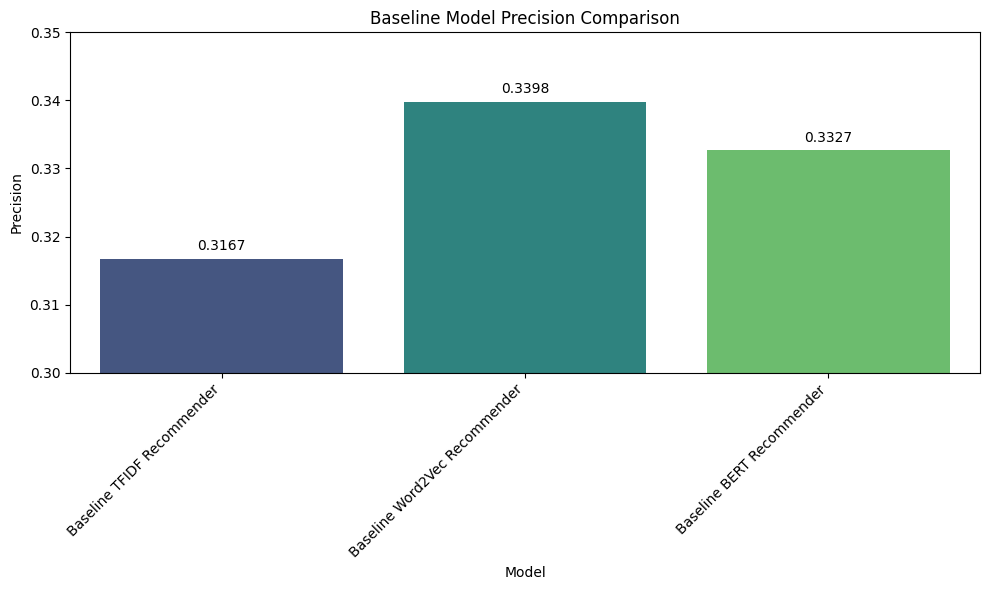

In [ ]:
# Filter for baseline models
df_baseline_results = results_df[results_df['Model'].str.contains('Baseline')]

# Plot for Baseline Models
plt.figure(figsize=(10, 6))
baseline_plot = sns.barplot(x="Model", y="Precision", data=df_baseline_results, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Baseline Model Precision Comparison")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.ylim(0.3, 0.35)  # Adjust the y-axis limit to start closer to the minimum precision value

# Annotate bars with precision values
for p in baseline_plot.patches:
    baseline_plot.annotate(format(p.get_height(), '.4f'),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha = 'center', va = 'center',
                           xytext = (0, 9),
                           textcoords = 'offset points')

plt.tight_layout()

# Display the plot
plt.show()

The Baseline TFIDF Recommender had a precision of 0.316743, with the Baseline Word2Vec Recommender scoring slightly higher at 0.339771. Both models employ cosine similarity on basic TFIDF and Word2Vec embeddings, respectively. Their relatively low precision scores indicate that, while they capture some relevance, there is plenty of room for improvement. The Baseline BERT Recommender, with a precision of 0.332673, outperforms the TFIDF baseline but is comparable to the Word2Vec baseline, demonstrating the fundamental level of relevance captured by the BERT embeddings alone. Among the baseline models, Word2Vec performed the best, highlighting its capability to capture semantic relationships in text.

### Advanced Models

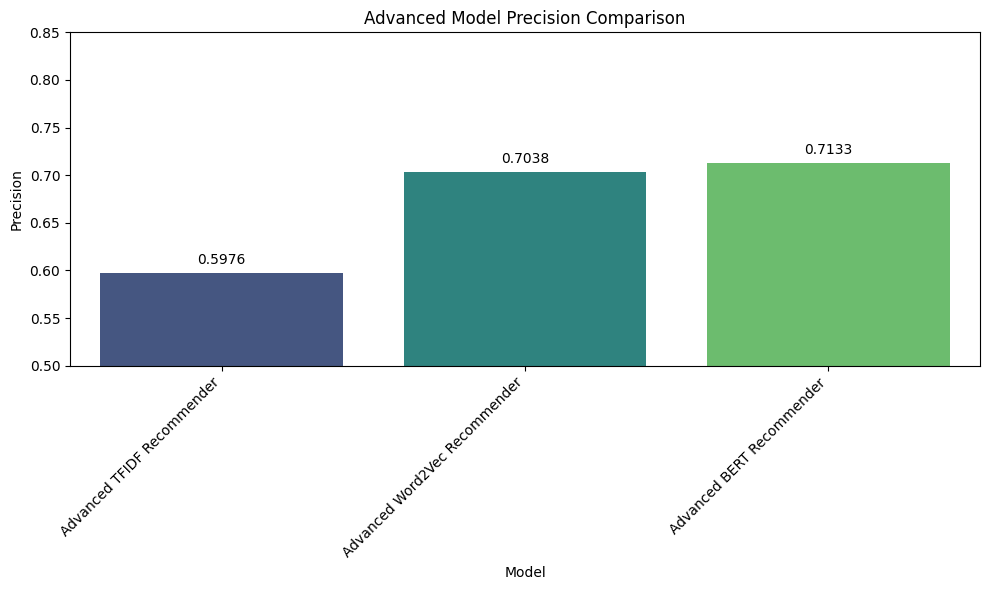

In [ ]:
# Filter for advanced models only
df_advanced_results = results_df[results_df['Model'].str.contains('Advanced')]

# Plot for Advanced Models with Adjusted Scale and Annotations
plt.figure(figsize=(10, 6))
advanced_plot = sns.barplot(x="Model", y="Precision", data=df_advanced_results, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Advanced Model Precision Comparison")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.ylim(0.5, 0.85)  # Adjust the y-axis limit to ensure all scores are visible

# Annotate bars with precision values
for p in advanced_plot.patches:
    advanced_plot.annotate(format(p.get_height(), '.4f'),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           xytext=(0, 9),
                           textcoords='offset points')

plt.tight_layout()

# Display the plot
plt.show()

#### Advanced Models
Incorporating additional features significantly improves precision across all advanced models. The Advanced TFIDF Recommender shows a notable increase in precision to 0.597629, indicating that the extra features add valuable information that enhances the relevance of the recommendations. The Advanced Word2Vec Recommender achieves a precision of 0.703803, demonstrating substantial improvement over its baseline counterpart. This improvement signifies that integrating additional features makes this model much more effective in providing relevant recommendations. The Advanced BERT Recommender, with a precision of 0.713317, achieves the highest precision among the purely advanced models. This suggests that BERT embeddings, combined with additional features, provide a very robust understanding of the content, leading to highly relevant recommendations. These results highlight the power of transfer learning, as the models leveraging pre-trained embeddings clearly outperformed the self-trained TFIDF approach in terms of precision.

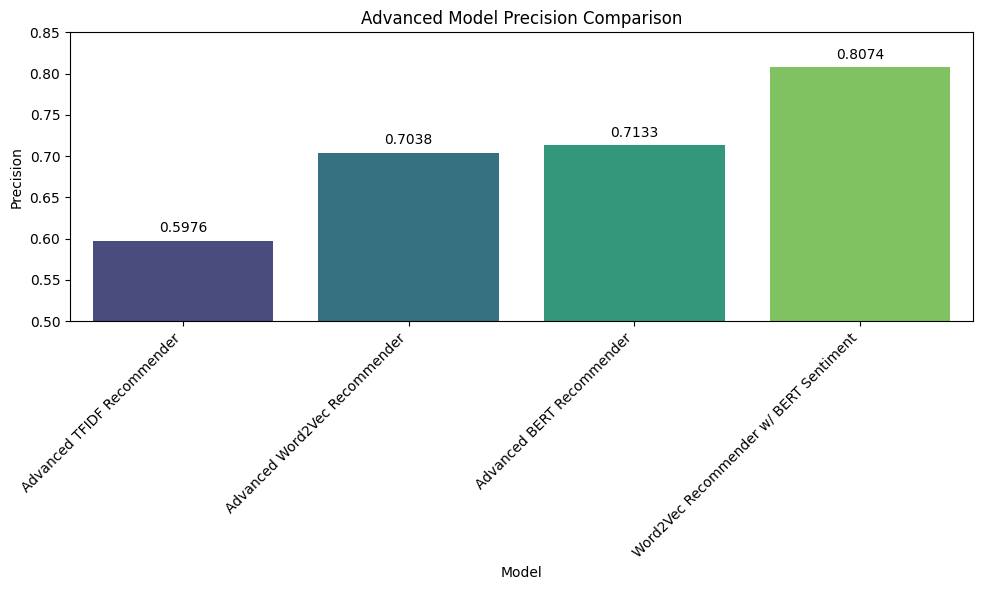

In [ ]:
# Filter for advanced models including hybrid model
df_advanced_results = results_df[results_df['Model'].str.contains('Advanced') | results_df['Model'].str.contains('BERT Sentiment')]

# Plot for Advanced Models with Adjusted Scale and Annotations
plt.figure(figsize=(10, 6))
advanced_plot = sns.barplot(x="Model", y="Precision", data=df_advanced_results, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Advanced Model Precision Comparison")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.ylim(0.5, 0.85)  # Adjust the y-axis limit to ensure all scores are visible

# Annotate bars with precision values
for p in advanced_plot.patches:
    advanced_plot.annotate(format(p.get_height(), '.4f'),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           xytext=(0, 9),
                           textcoords='offset points')

plt.tight_layout()

# Display the plot
plt.show()

#### Hybrid Model
The Word2Vec baseline model performed best in terms of cosine similarity, so combining it with the powerful BERT sentiment analysis is very reasonable. The Word2Vec Recommender with BERT Sentiment has the highest precision score (0.807405), outperforming all other models, including the advanced BERT model. This hybrid approach, which combines Word2Vec embeddings with BERT-based sentiment analysis, demonstrates the value of combining the strengths of two models: Word2Vec for semantic relationships and BERT for nuanced sentiment analysis. As expected, the additional weight assigned to sentiment polarity is a highly influential feature, resulting in the most relevant and accurate recommendations.

#### Conclusion
The evaluation reveals that adding more features significantly improves the precision of recommendations across all models. When considering cosine similarity and additional features, the BERT-based approach outperforms the other advanced models. However, the hybrid model that combines Word2Vec embeddings with BERT sentiment analysis has the highest precision, indicating that a multifaceted approach that takes advantage of the various models' strengths can result in the most relevant and accurate content-based recommendations.

# 3 Collaborative Filtering

For better comparability, we will load our Collaborative Filtering model from Part 1 again. Our final models will be compared against it to see how much we improved our recommendation system.

## 3.1 SVD Model

We will use Singular Value Decomposition (SVD) to create the collaborative filtering model. SVD is a matrix factorization technique that is commonly used for recommendation systems. It decomposes the user-item interaction matrix into different matrices. SVD helps in extracting latent factors that explain observed ratings, efficiently reducing data dimensionality while preserving essential information. This significantly speeds up calculations, making the process of predicting ratings more efficient, especially when dealing with a large dataset like ours. Additionally, by focusing on these latent factors, SVD enables a deeper understanding of user preferences and item characteristics, promising more personalized and accurate recommendations.

To compute SVD, we will use the surprise library. Surprise automatically handles normalization and scaling of the data as well as the handling of cold start and sparsity issues.

We will use a GridSearch to find the best combination of hyperparameter for the model.

In [ ]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()
testset = list(zip(test_data['userId'].values, test_data['movieId'].values, test_data['rating'].values))

# our grid of parameters
param_grid = {'n_factors': [50, 100],  # Number of factors
              'n_epochs': [20],         # Number of iterations
              'lr_all': [0.005, 0.01],      # Learning rate
              'reg_all': [0.02, 0.05]}      # Regularization term

svd = SVD()

best_rmse = float('inf')
best_params = None

# Loop through parameter combinations
for params in ParameterGrid(param_grid):
    svd = SVD(**params)
    svd.fit(trainset)

    predictions = svd.test(testset)

    # RMSE
    rmse = accuracy.rmse(predictions)

    # Update best RMSE and parameters if necessary
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best RMSE score obtained: ", best_rmse)
print("Best parameters: ", best_params)

RMSE: 0.8913
RMSE: 0.8829
RMSE: 0.8978
RMSE: 0.8840
RMSE: 0.9182
RMSE: 0.8831
RMSE: 0.9193
RMSE: 0.8844
Best RMSE score obtained:  0.8828869256424875
Best parameters:  {'lr_all': 0.005, 'n_epochs': 20, 'n_factors': 50, 'reg_all': 0.05}


The best RMSE score obtained is 0.88 with the following parameters:

lr_all: 0.005, n_epochs: 20, n_factors: 50, reg_all: 0.05

Let us now train the best version of our model and evaluate it on the test set with precision as metric.

In [ ]:
best_model = SVD(**best_params)
best_model.fit(trainset)

# Test the final model
final_predictions = best_model.test(testset)

# Function to calculate precision metric
def calculate_precision(predictions, threshold=3.5):
    true_positives = 0
    predicted_positives = 0

    for uid, iid, true_r, est, _ in predictions:
        if est >= threshold:
            predicted_positives += 1
            if true_r >= threshold:
                true_positives += 1

    if predicted_positives == 0:
        return 0

    precision = true_positives / predicted_positives
    return precision

# Calculate precision
precision = calculate_precision(final_predictions, threshold=4.0)
print(f"Precision: {precision:.4f}")

Precision: 0.8119


## 3.2 Neural Collaborative Filtering (NCF)

Now, we will implement the popular Neural Collaborative Filtering (NCF) algorithm for our movie recommendation system. NCF is a powerful algorithm that leverages neural networks to learn complex user-item interactions, making it particularly effective for recommendation tasks due to its ability to capture both linear and non-linear relationships.

NCF works by representing users and items with embedding vectors learned during training, which capture latent features. These embeddings are then combined using neural network architectures. The Generalized Matrix Factorization (GMF) approach computes the dot product of user and item embeddings, while the Multi-Layer Perceptron (MLP) approach concatenates the embeddings and passes them through multiple hidden layers. Neural Matrix Factorization (NeuMF) combines GMF and MLP to capture both linear and non-linear interactions, producing a prediction score that represents the estimated preference of a user for a given item.

In [ ]:
# Read data again to work with original data without any modifications from previous models
df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_100k.pkl')
df_movies = pd.read_pickle('/content/drive/My Drive/df_movies_cleaned.pkl')

### 3.2.1 Preprocessing

#### 3.2.1.1 Convert UserId & MovieId

Here, user IDs and movie IDs need to be converted to a continuous range of integers, which will serve as array indices in the embedding layers. Neural network models, particularly those using embeddings, benefit from having user and movie indices start from zero and continue without gaps. This is because each index directly accesses a position in the embedding matrix. This step ensures that each user and movie can be uniquely identified with a dense vector in the latent space.

In [ ]:
# Combine all movie IDs and user IDs from both dataframes to ensure comprehensive encoding
all_movie_ids = pd.concat([df_ratings['movieId'], df_movies['movieId']]).unique()
all_user_ids = df_ratings['userId'].unique()

# Create and fit the encoders
movie_encoder = LabelEncoder()
user_encoder = LabelEncoder()

movie_encoder.fit(all_movie_ids)
user_encoder.fit(all_user_ids)

# Transform movie and user IDs in the both dataframes
df_ratings['user'] = user_encoder.transform(df_ratings['userId'])
df_ratings['movie'] = movie_encoder.transform(df_ratings['movieId'])
df_movies['movie'] = movie_encoder.transform(df_movies['movieId'])

In [ ]:
# Check Encoding:

num_users = df_ratings['user'].nunique()
num_movies = df_ratings['movie'].nunique()

print("Unique users in ratings:", num_users)
print("Unique movies in ratings:", num_movies)
print("Min/Max user IDs:", df_ratings['user'].min(), '/', df_ratings['user'].max())
print("Min/Max movie IDs:", df_ratings['movie'].min(), '/', df_ratings['movie'].max())

Unique users in ratings: 55588
Unique movies in ratings: 9494
Min/Max user IDs: 0 / 55587
Min/Max movie IDs: 0 / 39082


User IDs appear to be correctly encoded. We have 55,588 unique users, and the user IDs range from 0 to 55,587, which suggests that every unique user ID has been mapped to a unique integer in a contiguous zero-based range.

Movie IDs, however, show a discrepancy. While there are 9,494 unique movies, the movie IDs range from 0 to 39,082. This gap indicates that not all possible integer values between 0 and 39,082 are used, suggesting that there are missing IDs within this range. Therefore, we will remap the movie IDs to a new contiguous range.

In [ ]:
# Recreate the mapping from the sorted unique IDs
movie_id_map = {id: i for i, id in enumerate(sorted(df_ratings['movieId'].unique()))}

# Apply the new mapping to the DataFrames
df_ratings['movie'] = df_ratings['movieId'].apply(lambda x: movie_id_map.get(x, -1))  # Use get to avoid errors
df_movies['movie'] = df_movies['movieId'].apply(lambda x: movie_id_map.get(x, -1))

# Check again
print("New max movie ID in ratings:", df_ratings['movie'].max())
print("New unique movie IDs in ratings:", df_ratings['movie'].nunique())

New max movie ID in ratings: 9493
New unique movie IDs in ratings: 9494


In [ ]:
print(df_ratings[['movieId', 'movie']].head())
print(df_movies[['movieId', 'movie']].head())

          movieId  movie
11800835     1037    829
3192182     27316   5716
10041143      307    269
14911364    73929   7389
13024846     4308   3281
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4


The mapping has now been applied correctly. The movie IDs now range from 0 to 9493, which matches exactly with the count of unique movie IDs (9494), implying that the IDs are perfectly contiguous and zero-indexed. Let's do a final validation check to confirm that no movieId is left unmapped and no erroneous transformations have occurred:

In [ ]:
# Ensure that all movies referenced in ratings are available in the movies DataFrame
missing_movies = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
if missing_movies.empty:
    print("All movies in ratings are accounted for in the movies dataframe.")
else:
    print(f"There are {missing_movies.shape[0]} missing movies in the movies dataframe.")

There are 781 missing movies in the movies dataframe.


The presence of 781 missing movies in the df_movies DataFrame compared to df_ratings indicates that there are movies which have been rated but for which there is no additional metadata available in the df_movies dataset. Those rows will be dropped as they are not significant for the model.

In [ ]:
# Removing ratings with missing movie metadata
df_ratings = df_ratings[df_ratings['movie'].isin(df_movies['movie'])]

# Check again
missing_movies_after = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
if missing_movies_after.empty:
    print("All movies in ratings are now accounted for in the movies dataframe.")
else:
    print(f"There are still {missing_movies_after.shape[0]} missing movies in the movies dataframe.")

All movies in ratings are now accounted for in the movies dataframe.


The data is now correctly encoded and we can move on to the next preprocessing step.

#### 3.2.1.2 Normalize Ratings

Next, we normalize the ratings as this helps the model train faster and converge more easily.

In [ ]:
# Normalize the ratings to a scale of 0 to 1
df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5

<ipython-input-48-e3f3ccd1ac68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5


In [ ]:
# Check Normalization:

print("Min/Max normalized ratings:", df_ratings['rating_norm'].min(), "/", df_ratings['rating_norm'].max())
print(df_ratings[['rating', 'rating_norm']].head())

Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


#### 3.2.1.3 Prepare Data for Modelling

Now, we split the data into training and test data. For recommendation tasks, a chronological split makes more sense than a random split because user preferences and item popularity can change over time. Using a chronological split can simulate a real-world scenario where a model trained on past data is used to predict future preferences. This approach helps in evaluating how well the model might perform when deployed in production, as it mimics the model's need to work with new, unseen data arriving over time.

In [ ]:
# Sort data chronologically
df_ratings = df_ratings.sort_values(by='timestamp')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define a cutoff for splitting the data (70% train, 15% validation, 15% test)
train_cutoff = int(len(df_ratings) * train_ratio)
val_cutoff = int(len(df_ratings) * (train_ratio + val_ratio))

train_df = df_ratings.iloc[:train_cutoff]
val_df = df_ratings.iloc[train_cutoff:val_cutoff]
test_df = df_ratings.iloc[val_cutoff:]

In [ ]:
# Separate user and item IDs for training, validation, and testing
X_train_user = train_df['user'].values
X_train_item = train_df['movie'].values
y_train = train_df['rating_norm'].values

X_val_user = val_df['user'].values
X_val_item = val_df['movie'].values
y_val = val_df['rating_norm'].values

X_test_user = test_df['user'].values
X_test_item = test_df['movie'].values
y_test = test_df['rating_norm'].values

# Convert to TensorFlow tensors
X_train_user = tf.convert_to_tensor(X_train_user, dtype=tf.int32)
X_train_item = tf.convert_to_tensor(X_train_item, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val_user = tf.convert_to_tensor(X_val_user, dtype=tf.int32)
X_val_item = tf.convert_to_tensor(X_val_item, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_test_user = tf.convert_to_tensor(X_test_user, dtype=tf.int32)
X_test_item = tf.convert_to_tensor(X_test_item, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
# Verify the shapes of the tensors
print(f"X_train_user shape: {X_train_user.shape}")
print(f"X_train_item shape: {X_train_item.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_user shape: {X_val_user.shape}")
print(f"X_val_item shape: {X_val_item.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"X_test_user shape: {X_test_user.shape}")
print(f"X_test_item shape: {X_test_item.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_user shape: (69453,)
X_train_item shape: (69453,)
y_train shape: (69453,)
X_val_user shape: (14883,)
X_val_item shape: (14883,)
y_val shape: (14883,)
X_test_user shape: (14883,)
X_test_item shape: (14883,)
y_test shape: (14883,)


In [ ]:
# Check Train-Test-Split:
print("Train data range from {} to {}".format(train_df['timestamp'].min(), train_df['timestamp'].max()))
print("Validation data range from {} to {}".format(val_df['timestamp'].min(), val_df['timestamp'].max()))
print("Test data range from {} to {}".format(test_df['timestamp'].min(), test_df['timestamp'].max()))

Train data range from 1996-02-15 12:59:58 to 2011-06-05 12:22:52
Validation data range from 2011-06-05 13:20:38 to 2015-11-07 15:07:54
Test data range from 2015-11-07 15:11:41 to 2017-08-04 03:38:23


### 3.2.2 Model Building

After the data preprocessing steps, we can now define the model architecture as previously described and train the model on our data.

#### 3.2.2.1 Define the NCF Model Architecture

In this model, the user and item inputs are embedded into 10-dimensional vectors for both the GMF and MLP parts. The GMF component multiplies the user and item embeddings, while the MLP component concatenates them and passes them through three dense layers with ReLU activations, reducing the dimensionality from 64 to 16. This structure allows the MLP part to capture complex, non-linear relationships between users and items.

The outputs of the GMF and MLP components are then concatenated and passed through additional dense layers to combine the linear and non-linear interaction features, further refining the representation before the final output. The final layer uses a sigmoid activation function to produce a prediction score between 0 and 1, representing the estimated preference of a user for a given item.

The model is compiled with the Adam optimizer for efficient gradient descent, and the loss function is mean squared error (MSE), which is the most appropriate for rating predictions.

In [ ]:
# Define model parameters
embedding_size = 10

# GMF part
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding_gmf = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_gmf')(user_input)
item_embedding_gmf = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_gmf')(item_input)
gmf_vector = Multiply()([Flatten()(user_embedding_gmf), Flatten()(item_embedding_gmf)])

# MLP part
user_embedding_mlp = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_mlp')(user_input)
item_embedding_mlp = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_mlp')(item_input)
mlp_vector = Concatenate()([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])

mlp_vector = Dense(64, activation='relu')(mlp_vector)
mlp_vector = Dense(32, activation='relu')(mlp_vector)
mlp_vector = Dense(16, activation='relu')(mlp_vector)

# Combine GMF and MLP parts
concatenated = Concatenate()([gmf_vector, mlp_vector])
result = Dense(10, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(result)

# Define a custom RMSE metric
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae', MeanSquaredError(name='mse'), root_mean_squared_error, Precision(thresholds=0.778, name='precision')]) # treshold of 0.778 (equivalent to 4 on a 0.5 - 5 scale)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']      

#### 3.2.2.2 Train the model

In [ ]:
# Train the model
history = model.fit(
    [X_train_user, X_train_item],
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=([X_val_user, X_val_item], y_val)
)

Epoch 1/20
272/272 [==============================] - 13s 33ms/step - loss: 0.0533 - mae: 0.1835 - mse: 0.0533 - root_mean_squared_error: 0.2300 - precision: 0.9984 - val_loss: 0.0496 - val_mae: 0.1717 - val_mse: 0.0496 - val_root_mean_squared_error: 0.2215 - val_precision: 0.9882
Epoch 2/20
272/272 [==============================] - 2s 9ms/step - loss: 0.0376 - mae: 0.1479 - mse: 0.0376 - root_mean_squared_error: 0.1936 - precision: 0.9989 - val_loss: 0.0516 - val_mae: 0.1763 - val_mse: 0.0516 - val_root_mean_squared_error: 0.2261 - val_precision: 0.9891
Epoch 3/20
272/272 [==============================] - 1s 5ms/step - loss: 0.0253 - mae: 0.1189 - mse: 0.0253 - root_mean_squared_error: 0.1586 - precision: 0.9998 - val_loss: 0.0531 - val_mae: 0.1779 - val_mse: 0.0531 - val_root_mean_squared_error: 0.2295 - val_precision: 0.9888
Epoch 4/20
272/272 [==============================] - 2s 7ms/step - loss: 0.0162 - mae: 0.0947 - mse: 0.0162 - root_mean_squared_error: 0.1272 - precision: 0.

#### 3.2.2.3 Evaluate the model

Let's evaluate the model by applying it to a test set that it has not seen before, visualizing the metric evolution across epochs and printing the first 10 movies for an exemplary user.

In [ ]:
# Evaluate model on the test set
results = model.evaluate([X_test_user, X_test_item], y_test, verbose=1)

466/466 [==============================] - 1s 2ms/step - loss: 0.0562 - mae: 0.1852 - mse: 0.0562 - root_mean_squared_error: 0.2340 - precision: 0.9839


In [ ]:
# Scale back MAE, MSE, and RMSE to the original rating scale (0.5 to 5)
scale_factor = 4.5
scaled_mae = results[1] * scale_factor
scaled_mse = results[2] * (scale_factor ** 2)
scaled_rmse = results[3] * scale_factor

# Print all metrics
print("Test Loss (MSE): {:.4f}".format(results[0]))
print("Test MAE: {:.4f}".format(scaled_mae))
print("Test MSE: {:.4f}".format(scaled_mse))
print("Test RMSE: {:.4f}".format(scaled_rmse))
print("Test Precision: {:.4f}".format(results[4]))

Test Loss (MSE): 0.0562
Test MAE: 0.8333
Test MSE: 1.1389
Test RMSE: 1.0528
Test Precision: 0.9839


In [ ]:
# Function to visualize results
def visualize_results(history):
    """Generate plots to visualize model results."""
    plt.figure(figsize=(18, 10))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot MAE
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Epochs')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('MSE Over Epochs')
    plt.legend()

    # Plot RMSE
    plt.subplot(2, 2, 4)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('RMSE Over Epochs')
    plt.legend()

    plt.show()

    # Plot Precision
    if 'precision' in history.history:
        plt.figure(figsize=(9, 5))
        plt.plot(history.history['precision'], label='Train Precision')
        plt.plot(history.history['val_precision'], label='Validation Precision')
        plt.title('Precision Over Epochs')
        plt.legend()
        plt.show()

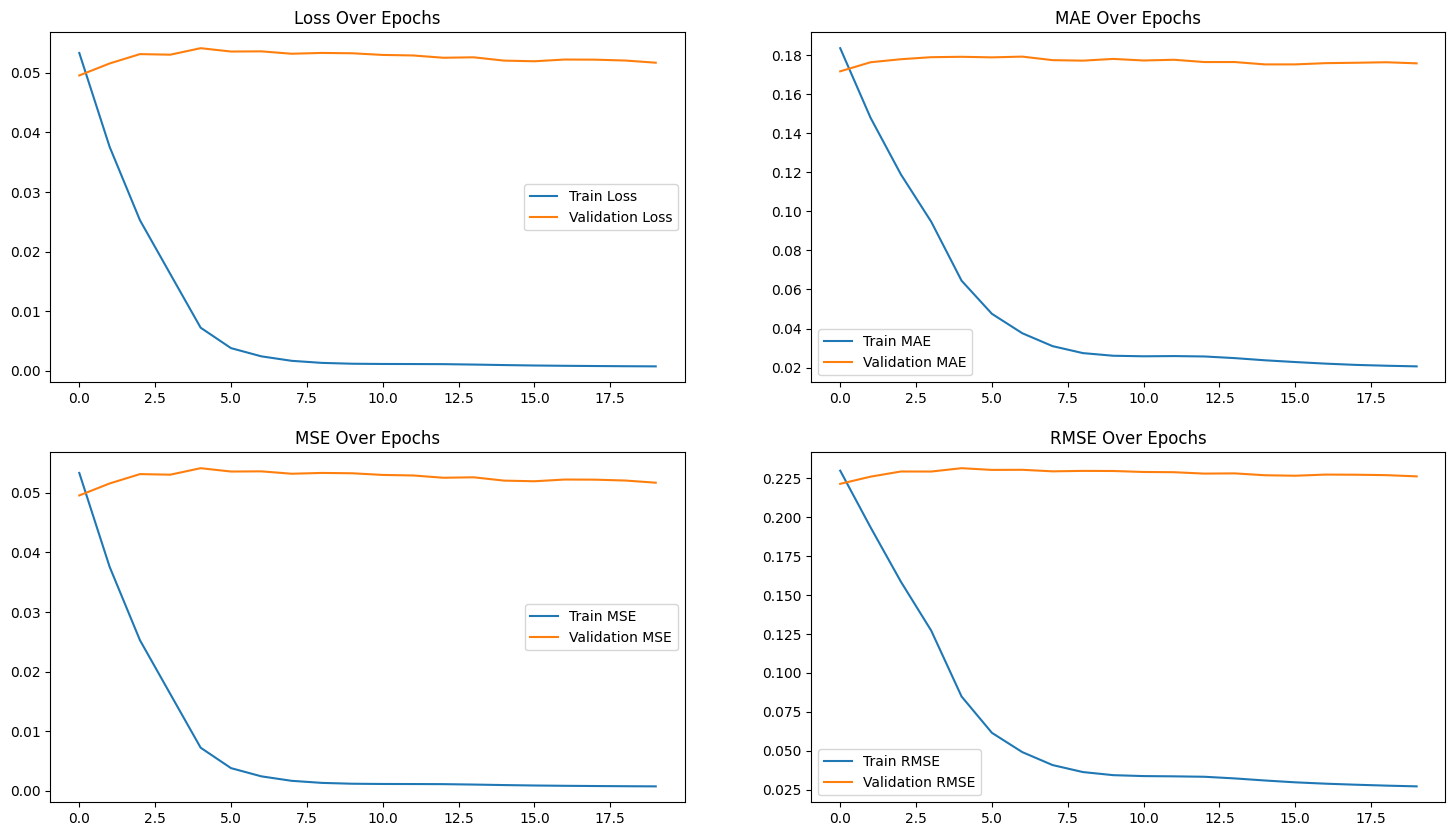

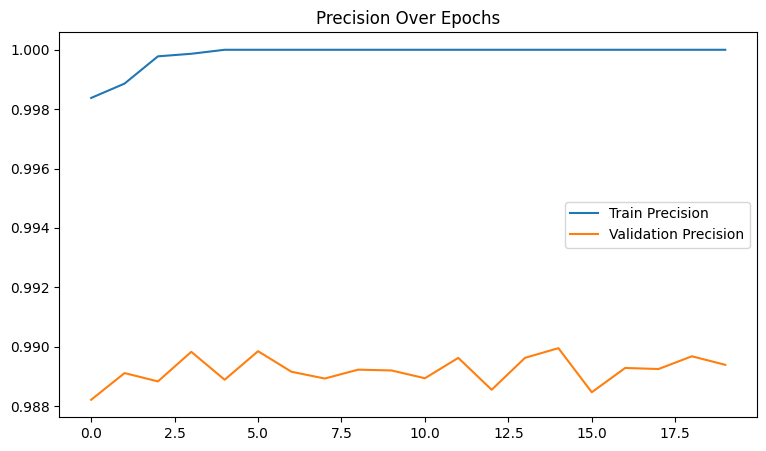

In [ ]:
visualize_results(history)

In [ ]:
# Select an exemplary user
exemplary_user_id = 4

# Encode the exemplary user ID
encoded_user_id = user_encoder.transform([exemplary_user_id])[0]

# Get a list of all movie IDs
all_movie_ids = df_movies['movie'].unique()

# Get the list of movies the user has already rated
rated_movies = df_ratings[df_ratings['userId'] == exemplary_user_id]['movieId'].unique()

# Filter out the movies the user has already rated
unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movies)

# Prepare input data for the model
user_input = np.full(len(unrated_movie_ids), encoded_user_id)
movie_input = unrated_movie_ids

# Convert to TensorFlow tensors
user_input_tensor = tf.convert_to_tensor(user_input, dtype=tf.int32)
movie_input_tensor = tf.convert_to_tensor(movie_input, dtype=tf.int32)

# Make predictions
predicted_ratings_scaled = model.predict([user_input_tensor, movie_input_tensor])
predicted_ratings = predicted_ratings_scaled * 4.5 + 0.5

# Combine movie IDs with their predicted ratings
movie_ratings = list(zip(movie_input, predicted_ratings.flatten()))

# Sort movies by predicted rating in descending order
sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

# Get top-N recommendations
top_n = 10
top_n_recommendations = sorted_movie_ratings[:top_n]

# Print top-N recommendations
print(f"Top {top_n} movie recommendations for User {exemplary_user_id}:")
for i, (movie_id, predicted_rating) in enumerate(top_n_recommendations, start=1):
    original_movie_id = movie_encoder.inverse_transform([movie_id])[0]
    movie_title = df_movies[df_movies['movieId'] == original_movie_id]['title'].values[0]
    print(f"Rank {i}: Movie ID {original_movie_id}, Title: {movie_title}, Predicted Rating: {predicted_rating: .2f}")

289/289 [==============================] - 1s 1ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 1020, Title: Cool Runnings, Predicted Rating:  4.39
Rank 2: Movie ID 2619, Title: Mascara, Predicted Rating:  4.38
Rank 3: Movie ID 3333, Title: The Killing of Sister George, Predicted Rating:  4.36
Rank 4: Movie ID 290, Title: Once Were Warriors, Predicted Rating:  4.30
Rank 5: Movie ID 3607, Title: One Little Indian, Predicted Rating:  4.28
Rank 6: Movie ID 728, Title: Cold Comfort Farm, Predicted Rating:  4.28
Rank 7: Movie ID 1099, Title: A Christmas Carol, Predicted Rating:  4.27
Rank 8: Movie ID 2618, Title: The Castle, Predicted Rating:  4.27
Rank 9: Movie ID 1067, Title: A Damsel in Distress, Predicted Rating:  4.26
Rank 10: Movie ID 1302, Title: Field of Dreams, Predicted Rating:  4.25


**Interpretation:**

The test results indicate a Test Loss (MSE) of 0.0562, which suggests the model's prediction errors are relatively small on average. The Mean Absolute Error (MAE) on the test set is 0.8333, indicating that the average absolute difference between the predicted and actual ratings is about 0.83. This MAE value, while not perfect, shows that the model's predictions are reasonably close to the true ratings. The Test MSE of 1.1389 and RMSE of 1.0528 further corroborate the model's effectiveness in minimizing prediction errors, with RMSE providing a more interpretable error metric by being in the same units as the original ratings.

The precision metric, calculated at 0.9839, demonstrates the model's high accuracy in predicting relevant items for users. This means that 98.39% of the items that the model predicted as relevant (above the threshold 4) were indeed relevant based on the test set.

The plots of the metric evolution over epochs illustrate that while the training metrics (MSE, RMSE, and Precision) improve consistently, the validation metrics exhibit a degree of stability with minor fluctuations, particularly in precision. This suggests that the model generalizes well to unseen data without significant overfitting.

#### 3.2.2.4 Harnessing larger datasets

Now, given the fact that Deep Neural Networks perform better and better the more data they are given, we will try our model with bigger datasets, namely one dataset with 1 million entries and another one with 3 million entries (as opposed to 100k in the first iteration).

**1. Define Functions**

Now, let's define functions with the preprocessing and modelling steps which we did before.

In [ ]:
def prepare_data(df_ratings, df_movies):
  # Combine all movie IDs and user IDs from both dataframes to ensure comprehensive encoding
  all_movie_ids = pd.concat([df_ratings['movieId'], df_movies['movieId']]).unique()
  all_user_ids = df_ratings['userId'].unique()

  # Create and fit the encoders
  movie_encoder = LabelEncoder()
  user_encoder = LabelEncoder()

  movie_encoder.fit(all_movie_ids)
  user_encoder.fit(all_user_ids)

  # Transform movie and user IDs in the both dataframes
  df_ratings['user'] = user_encoder.transform(df_ratings['userId'])
  df_ratings['movie'] = movie_encoder.transform(df_ratings['movieId'])
  df_movies['movie'] = movie_encoder.transform(df_movies['movieId'])

  # Check Encoding:
  num_users = df_ratings['user'].nunique()
  num_movies = df_ratings['movie'].nunique()

  print("Unique users in ratings:", num_users)
  print("Unique movies in ratings:", num_movies)
  print("Min/Max user IDs:", df_ratings['user'].min(), '/', df_ratings['user'].max())
  print("Min/Max movie IDs:", df_ratings['movie'].min(), '/', df_ratings['movie'].max())

  # Recreate the mapping from the sorted unique IDs
  movie_id_map = {id: i for i, id in enumerate(sorted(df_ratings['movieId'].unique()))}

  # Apply the new mapping to the DataFrames
  df_ratings['movie'] = df_ratings['movieId'].apply(lambda x: movie_id_map.get(x, -1))  # Use get to avoid errors
  df_movies['movie'] = df_movies['movieId'].apply(lambda x: movie_id_map.get(x, -1))

  # Check again
  print("New max movie ID in ratings:", df_ratings['movie'].max())
  print("New unique movie IDs in ratings:", df_ratings['movie'].nunique())

  print(df_ratings[['movieId', 'movie']].head())
  print(df_movies[['movieId', 'movie']].head())

  # Ensure that all movies referenced in ratings are available in the movies DataFrame
  missing_movies = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
  if missing_movies.empty:
      print("All movies in ratings are accounted for in the movies dataframe.")
  else:
      print(f"There are {missing_movies.shape[0]} missing movies in the movies dataframe.")

  # Removing ratings with missing movie metadata
  df_ratings = df_ratings[df_ratings['movie'].isin(df_movies['movie'])]

  # Check again
  missing_movies_after = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
  if missing_movies_after.empty:
      print("All movies in ratings are now accounted for in the movies dataframe.")
  else:
      print(f"There are still {missing_movies_after.shape[0]} missing movies in the movies dataframe.")

  # Normalize the ratings to a scale of 0 to 1
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5

  # Check Normalization:
  print("Min/Max normalized ratings:", df_ratings['rating_norm'].min(), "/", df_ratings['rating_norm'].max())
  print(df_ratings[['rating', 'rating_norm']].head())

  # Sort data chronologically
  df_ratings = df_ratings.sort_values(by='timestamp')

  # Define split ratios
  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15

  # Define a cutoff for splitting the data (70% train, 15% validation, 15% test)
  train_cutoff = int(len(df_ratings) * train_ratio)
  val_cutoff = int(len(df_ratings) * (train_ratio + val_ratio))

  train_df = df_ratings.iloc[:train_cutoff]
  val_df = df_ratings.iloc[train_cutoff:val_cutoff]
  test_df = df_ratings.iloc[val_cutoff:]

  # Separate user and item IDs for training, validation, and testing
  X_train_user = train_df['user'].values
  X_train_item = train_df['movie'].values
  y_train = train_df['rating_norm'].values

  X_val_user = val_df['user'].values
  X_val_item = val_df['movie'].values
  y_val = val_df['rating_norm'].values

  X_test_user = test_df['user'].values
  X_test_item = test_df['movie'].values
  y_test = test_df['rating_norm'].values

  # Convert to TensorFlow tensors
  X_train_user = tf.convert_to_tensor(X_train_user, dtype=tf.int32)
  X_train_item = tf.convert_to_tensor(X_train_item, dtype=tf.int32)
  y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

  X_val_user = tf.convert_to_tensor(X_val_user, dtype=tf.int32)
  X_val_item = tf.convert_to_tensor(X_val_item, dtype=tf.int32)
  y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

  X_test_user = tf.convert_to_tensor(X_test_user, dtype=tf.int32)
  X_test_item = tf.convert_to_tensor(X_test_item, dtype=tf.int32)
  y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

  # Verify the shapes of the tensors
  print(f"X_train_user shape: {X_train_user.shape}")
  print(f"X_train_item shape: {X_train_item.shape}")
  print(f"y_train shape: {y_train.shape}")

  print(f"X_val_user shape: {X_val_user.shape}")
  print(f"X_val_item shape: {X_val_item.shape}")
  print(f"y_val shape: {y_val.shape}")

  print(f"X_test_user shape: {X_test_user.shape}")
  print(f"X_test_item shape: {X_test_item.shape}")
  print(f"y_test shape: {y_test.shape}")

  # Check Train-Test-Split:
  print("Train data range from {} to {}".format(train_df['timestamp'].min(), train_df['timestamp'].max()))
  print("Validation data range from {} to {}".format(val_df['timestamp'].min(), val_df['timestamp'].max()))
  print("Test data range from {} to {}".format(test_df['timestamp'].min(), test_df['timestamp'].max()))

  return X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, X_test_user, X_test_item, y_test, user_encoder, movie_encoder

In [ ]:
def build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies, embedding_size=10, epochs=20, batch_size=256):
    # GMF part
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    user_embedding_gmf = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_gmf')(user_input)
    item_embedding_gmf = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_gmf')(item_input)
    gmf_vector = Multiply()([Flatten()(user_embedding_gmf), Flatten()(item_embedding_gmf)])

    # MLP part
    user_embedding_mlp = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_mlp')(user_input)
    item_embedding_mlp = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_mlp')(item_input)
    mlp_vector = Concatenate()([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])

    mlp_vector = Dense(64, activation='relu')(mlp_vector)
    mlp_vector = Dense(32, activation='relu')(mlp_vector)
    mlp_vector = Dense(16, activation='relu')(mlp_vector)

    # Combine GMF and MLP parts
    concatenated = Concatenate()([gmf_vector, mlp_vector])
    result = Dense(10, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(result)

    # Define a custom RMSE metric
    def root_mean_squared_error(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mae', MeanSquaredError(name='mse'), root_mean_squared_error, Precision(thresholds=0.778, name='precision')])
    model.summary()

    # Train the model
    history = model.fit(
        [X_train_user, X_train_item],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_val_user, X_val_item], y_val)
    )

    return model, history

In [ ]:
def evaluate_model(model, X_test_user, X_test_item, y_test):
    # Evaluate model on the test set
    results = model.evaluate([X_test_user, X_test_item], y_test, verbose=1)

    # Scale back MAE, MSE, and RMSE to the original rating scale (0.5 to 5)
    scale_factor = 4.5
    scaled_mae = results[1] * scale_factor
    scaled_mse = results[2] * (scale_factor ** 2)
    scaled_rmse = results[3] * scale_factor

    # Print all metrics
    print("Test Loss (MSE): {:.4f}".format(results[0]))
    print("Test MAE: {:.4f}".format(scaled_mae))
    print("Test MSE: {:.4f}".format(scaled_mse))
    print("Test RMSE: {:.4f}".format(scaled_rmse))
    print("Test Precision: {:.2f}%".format(results[4] * 100))

In [ ]:
def get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies, top_n=10):
    # Encode the exemplary user ID
    encoded_user_id = user_encoder.transform([exemplary_user_id])[0]

    # Get a list of all movie IDs
    all_movie_ids = df_movies['movie'].unique()

    # Get the list of movies the user has already rated
    rated_movies = df_ratings[df_ratings['userId'] == exemplary_user_id]['movieId'].unique()

    # Filter out the movies the user has already rated
    unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movies)

    # Prepare input data for the model
    user_input = np.full(len(unrated_movie_ids), encoded_user_id)
    movie_input = unrated_movie_ids

    # Convert to TensorFlow tensors
    user_input_tensor = tf.convert_to_tensor(user_input, dtype=tf.int32)
    movie_input_tensor = tf.convert_to_tensor(movie_input, dtype=tf.int32)

    # Make predictions
    predicted_ratings_scaled = model.predict([user_input_tensor, movie_input_tensor])
    predicted_ratings = predicted_ratings_scaled * 4.5 + 0.5

    # Combine movie IDs with their predicted ratings
    movie_ratings = list(zip(movie_input, predicted_ratings.flatten()))

    # Sort movies by predicted rating in descending order
    sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

    # Get top-N recommendations
    top_n_recommendations = sorted_movie_ratings[:top_n]

    # Print top-N recommendations
    print(f"Top {top_n} movie recommendations for User {exemplary_user_id}:")
    for i, (movie_id, predicted_rating) in enumerate(top_n_recommendations, start=1):
        original_movie_id = movie_encoder.inverse_transform([movie_id])[0]
        movie_title = df_movies[df_movies['movieId'] == original_movie_id]['title'].values[0]
        print(f"Rank {i}: Movie ID {original_movie_id}, Title: {movie_title}, Predicted Rating: {predicted_rating:.2f}")

**2. 1 Mio. Dataset**

In [ ]:
# 1 Mio Ratings:

df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_1M.pkl')

In [ ]:
# Prepare data
prepare_data(df_ratings, df_movies)

Unique users in ratings: 145430
Unique movies in ratings: 19596
Min/Max user IDs: 0 / 145429
Min/Max movie IDs: 0 / 40057
New max movie ID in ratings: 19595
New unique movie IDs in ratings: 19596
          movieId  movie
11800835     1037    985
3192182     27316   8398
10041143      307    302
14911364    73929  12086
13024846     4308   4059
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4
There are 7743 missing movies in the movies dataframe.
All movies in ratings are now accounted for in the movies dataframe.
Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


<ipython-input-24-bc499fa49e4f>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5


X_train_user shape: (694580,)
X_train_item shape: (694580,)
y_train shape: (694580,)
X_val_user shape: (148839,)
X_val_item shape: (148839,)
y_val shape: (148839,)
X_test_user shape: (148839,)
X_test_item shape: (148839,)
y_test shape: (148839,)
Train data range from 1996-02-01 14:33:33 to 2011-04-28 02:16:07
Validation data range from 2011-04-28 02:18:17 to 2015-11-04 05:54:57
Test data range from 2015-11-04 06:02:22 to 2017-08-04 06:07:50


(<tf.Tensor: shape=(694580,), dtype=int32, numpy=array([ 51159, 116612, 123709, ...,  29189,  29189,  29189], dtype=int32)>,
 <tf.Tensor: shape=(694580,), dtype=int32, numpy=array([  62,   47,   86, ..., 8620, 6463, 2251], dtype=int32)>,
 <tf.Tensor: shape=(694580,), dtype=float32, numpy=
 array([0.11111111, 0.5555556 , 0.5555556 , ..., 0.7777778 , 0.7777778 ,
        0.44444445], dtype=float32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([29189, 29189, 29189, ..., 46154, 46154, 73222], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([ 1858,  9791, 11037, ...,  8748,  6607,  7728], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=float32, numpy=
 array([0.22222222, 0.6666667 , 0.6666667 , ..., 1.        , 1.        ,
        0.7777778 ], dtype=float32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([ 79401,  46154,  79401, ..., 108576, 108576, 108576], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([11238,   357,  46

In [ ]:
# Build and train the model
model, history = build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']    

In [ ]:
# Evaluate the model
evaluate_model(model, X_test_user, X_test_item, y_test)

466/466 [==============================] - 1s 2ms/step - loss: 0.0557 - mae: 0.1840 - mse: 0.0557 - root_mean_squared_error: 0.2329 - precision: 0.9859
Test Loss (MSE): 0.0557
Test MAE: 0.8280
Test MSE: 1.1278
Test RMSE: 1.0479
Test Precision: 98.59%


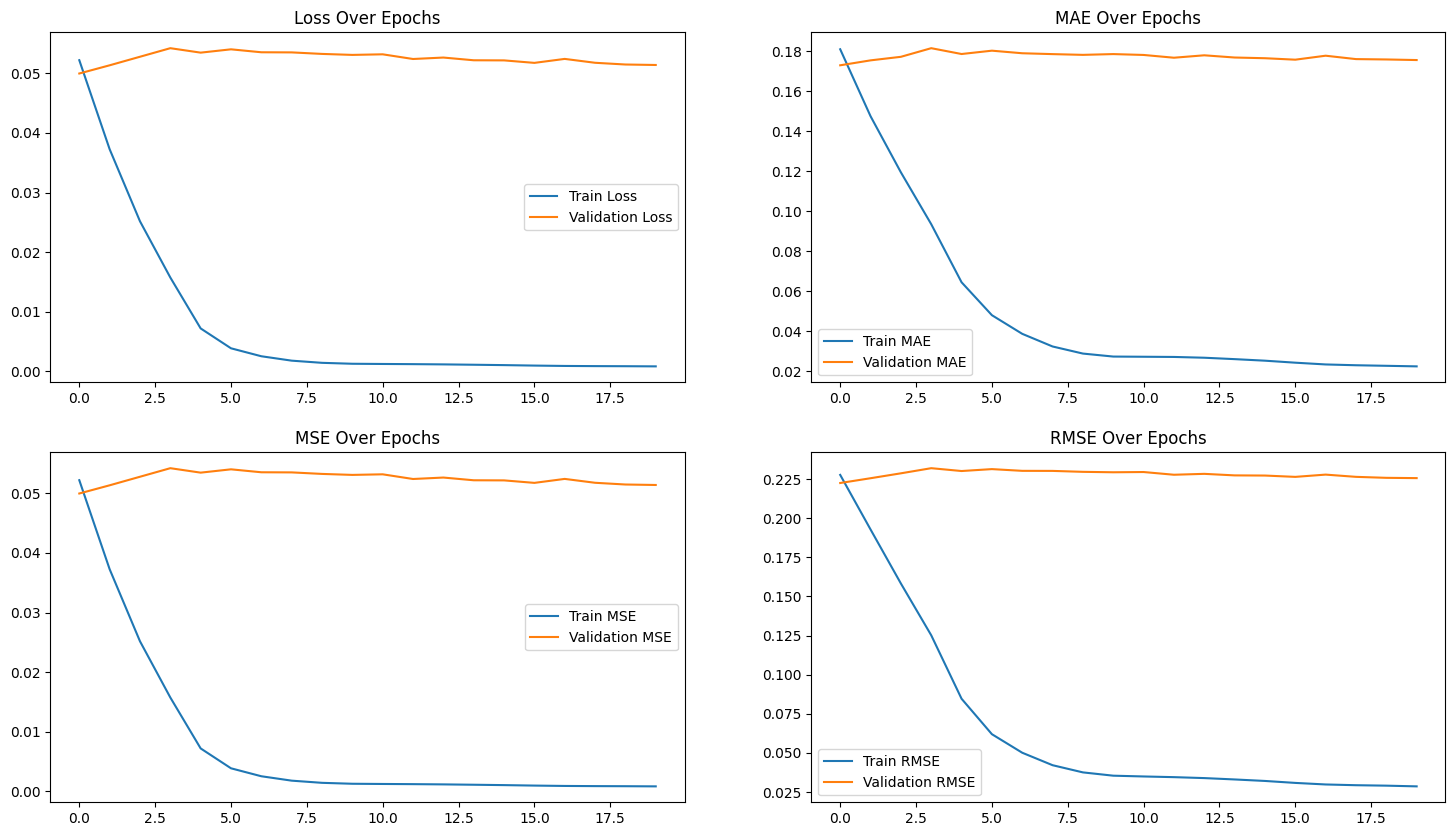

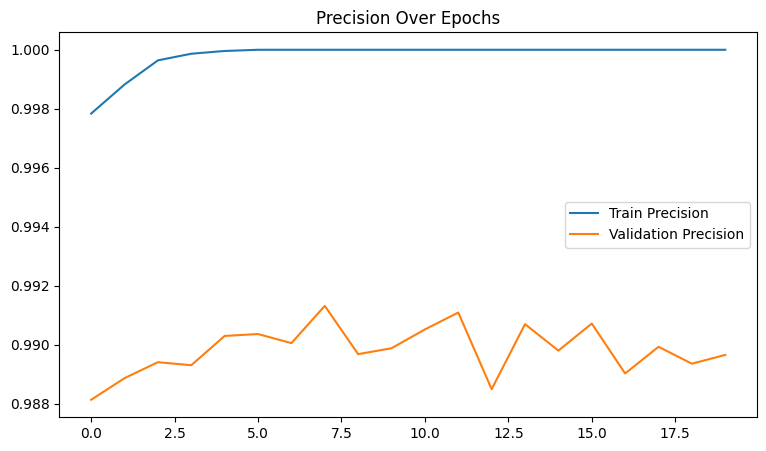

In [ ]:
visualize_results(history)

In [ ]:
# Get recommendations for an exemplary user
exemplary_user_id = 4
get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies)

575/575 [==============================] - 1s 1ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 1757, Title: Fallen Angels, Predicted Rating: 4.51
Rank 2: Movie ID 1043, Title: To Gillian on Her 37th Birthday, Predicted Rating: 4.45
Rank 3: Movie ID 1020, Title: Cool Runnings, Predicted Rating: 4.42
Rank 4: Movie ID 2618, Title: The Castle, Predicted Rating: 4.41
Rank 5: Movie ID 3409, Title: Final Destination, Predicted Rating: 4.40
Rank 6: Movie ID 1099, Title: A Christmas Carol, Predicted Rating: 4.38
Rank 7: Movie ID 728, Title: Cold Comfort Farm, Predicted Rating: 4.34
Rank 8: Movie ID 482, Title: Killing Zoe, Predicted Rating: 4.32
Rank 9: Movie ID 774, Title: God's Gift, Predicted Rating: 4.31
Rank 10: Movie ID 2501, Title: October Sky, Predicted Rating: 4.29


**3. 3 Mio. Dataset**

In [ ]:
# 3 Mio Ratings:

df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_3M.pkl')

In [ ]:
# Prepare data
prepare_data(df_ratings, df_movies)

Unique users in ratings: 164638
Unique movies in ratings: 26876
Min/Max user IDs: 0 / 164637
Min/Max movie IDs: 0 / 41078
New max movie ID in ratings: 26875
New unique movie IDs in ratings: 26876
          movieId  movie
11800835     1037   1011
3192182     27316   9021
10041143      307    304
14911364    73929  13711
13024846     4308   4173
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4
There are 22910 missing movies in the movies dataframe.
All movies in ratings are now accounted for in the movies dataframe.
Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


<ipython-input-24-bc499fa49e4f>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5


X_train_user shape: (2083963,)
X_train_item shape: (2083963,)
y_train shape: (2083963,)
X_val_user shape: (446564,)
X_val_item shape: (446564,)
y_val shape: (446564,)
X_test_user shape: (446564,)
X_test_item shape: (446564,)
y_test shape: (446564,)
Train data range from 1996-01-29 00:00:00 to 2011-04-29 02:10:57
Validation data range from 2011-04-29 02:11:19 to 2015-11-04 08:48:36
Test data range from 2015-11-04 08:48:45 to 2017-08-04 06:57:50


(<tf.Tensor: shape=(2083963,), dtype=int32, numpy=array([ 27632,  27632, 116093, ...,  54448,  87241,  54448], dtype=int32)>,
 <tf.Tensor: shape=(2083963,), dtype=int32, numpy=array([   1,   47,   10, ..., 1906, 6932,  373], dtype=int32)>,
 <tf.Tensor: shape=(2083963,), dtype=float32, numpy=
 array([0.7777778, 0.7777778, 0.7777778, ..., 0.5555556, 0.8888889,
        0.6666667], dtype=float32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([54448, 33116, 54448, ..., 48681, 48681, 48681], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([5120, 9183, 6469, ...,  471,    6, 5331], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=float32, numpy=
 array([0.5555556 , 0.7777778 , 0.44444445, ..., 0.22222222, 0.44444445,
        0.44444445], dtype=float32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([103020,  48681,  48681, ..., 122806, 122806, 108999], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([12423, 14954,  2820, ..., 

In [ ]:
# Build and train the model
model, history = build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']    

In [ ]:
# Evaluate the model
evaluate_model(model, X_test_user, X_test_item, y_test)

466/466 [==============================] - 1s 2ms/step - loss: 0.0562 - mae: 0.1843 - mse: 0.0562 - root_mean_squared_error: 0.2338 - precision: 0.9852
Test Loss (MSE): 0.0562
Test MAE: 0.8294
Test MSE: 1.1372
Test RMSE: 1.0523
Test Precision: 98.52%


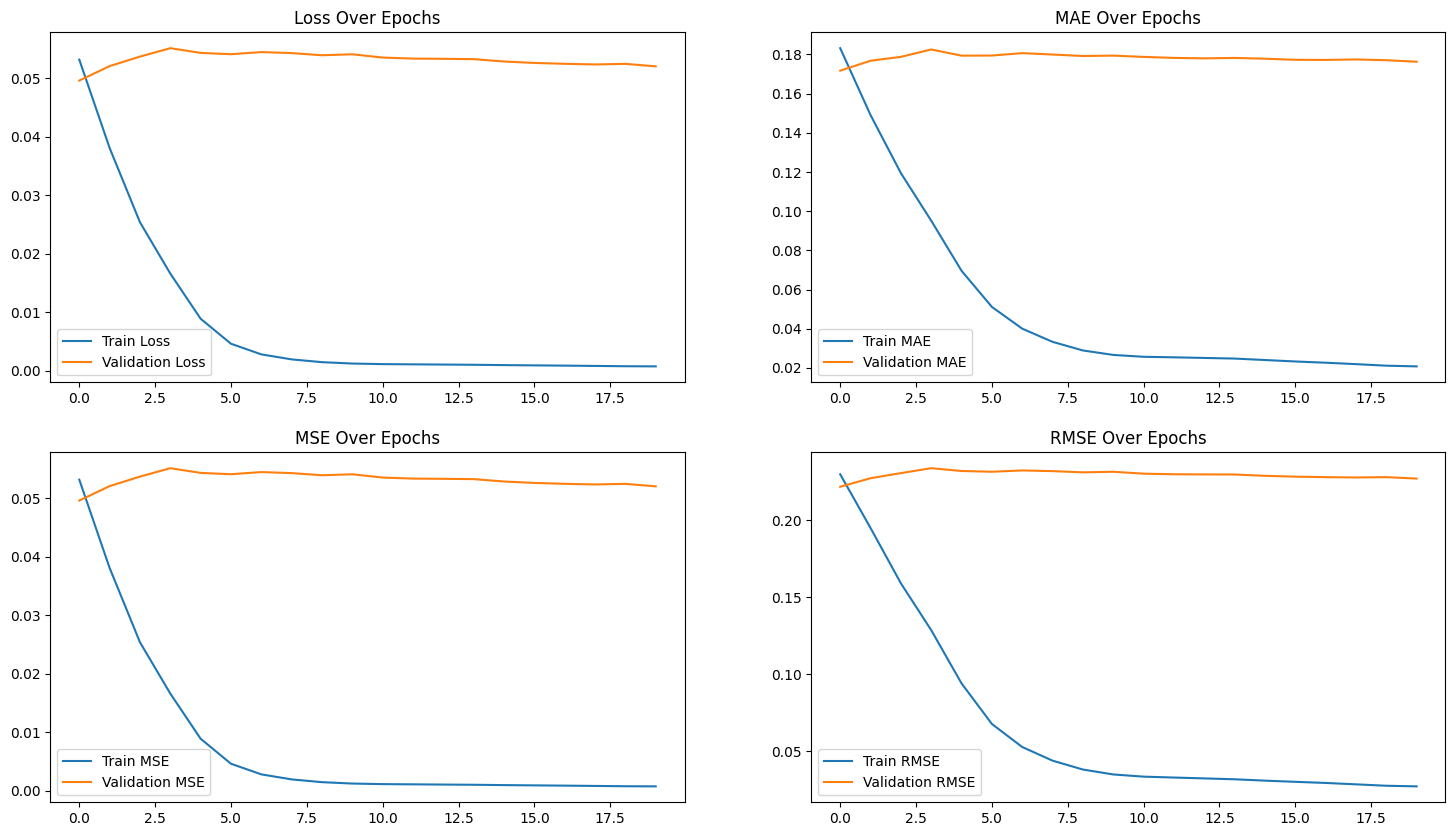

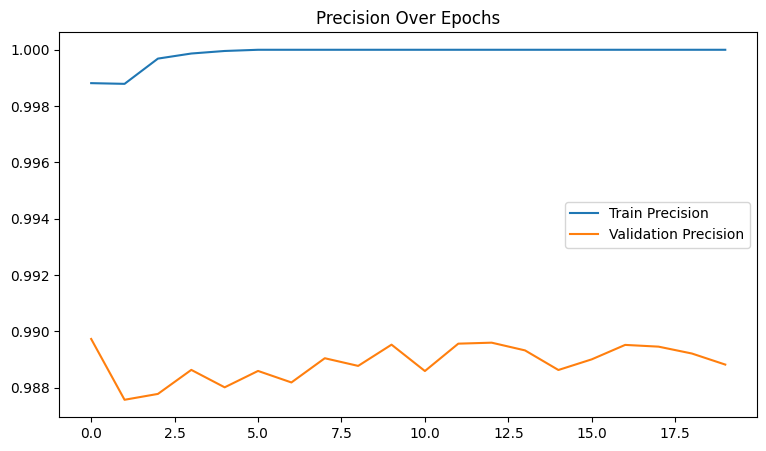

In [ ]:
visualize_results(history)

In [ ]:
# Get recommendations for an exemplary user
exemplary_user_id = 4
get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies)

771/771 [==============================] - 1s 2ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 1757, Title: Fallen Angels, Predicted Rating: 4.49
Rank 2: Movie ID 1020, Title: Cool Runnings, Predicted Rating: 4.36
Rank 3: Movie ID 1032, Title: Alice in Wonderland, Predicted Rating: 4.23
Rank 4: Movie ID 1695, Title: Artemisia, Predicted Rating: 4.22
Rank 5: Movie ID 1957, Title: Chariots of Fire, Predicted Rating: 4.21
Rank 6: Movie ID 2501, Title: October Sky, Predicted Rating: 4.20
Rank 7: Movie ID 482, Title: Killing Zoe, Predicted Rating: 4.16
Rank 8: Movie ID 2619, Title: Mascara, Predicted Rating: 4.14
Rank 9: Movie ID 1899, Title: Passion in the Desert, Predicted Rating: 4.10
Rank 10: Movie ID 2658, Title: The Flying Saucer, Predicted Rating: 4.09


**Interpretation:**

The performance metrics for the model remain largely consistent across different dataset sizes. When increasing the dataset size to 1 million entries, the model achieves slightly better performance metrics compared to the initial 100k dataset. However, the improvements are marginal, with Test Loss (MSE), Test MSE, and Test RMSE showing only minor reductions and precision improving slightly to 98.59%.

With 3 million entries, the performance metrics are very similar to those obtained with 1 million entries. The Test Loss (MSE), Test MAE, Test MSE, and Test RMSE show minimal differences, and precision remains high at 98.52%.

These results indicate that increasing the dataset size did not bring significant benefits in terms of performance improvement. The metrics stay pretty much the same, suggesting that the model's ability to generalize and make accurate predictions does not significantly improve with more data beyond a certain point. Therefore, training the model with larger datasets did not provide substantial advantages in this case.

## 3.3 Keras Model

For this section of our project, we've selected Keras due to its user-friendly, high-level API, which facilitates rapid prototyping—a crucial advantage when exploring various collaborative filtering techniques. Keras also provides a wide range of pre-built layers, optimizers, and loss functions, making it easy to build and train complex neural network models for recommendation systems. As a component of the TensorFlow ecosystem, Keras offers robust support for deep learning operations.
We will use the 3M dataset for this part of the project.

In [ ]:
df_merged = pd.read_pickle('/content/drive/My Drive/df_merged_cleaned.pkl')
df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_3M.pkl') # Adjust the dataset depending on the size needed

### 3.3.1 Ratings Preprocessing

We will now preprocess the Ratings Dataframe in order to use it for the later model.

In [ ]:
# Make sure that the timestamp is in seconds
df_ratings['timestamp'] = df_ratings['timestamp'].astype('int64') // 10**9

# Keep only relevant columns
df_ratings = df_ratings[['userId', 'movieId', 'rating', 'timestamp']]

# Make userId the index
#df_ratings.set_index('userId', inplace=True)

# Delete index
df_ratings.reset_index(drop=True, inplace=True)

df_ratings.head()

,userId,movieId,rating,timestamp
0,128365,1037,0.5,1255947037
1,34770,27316,0.5,1149930873
2,108700,307,0.5,1273699572
3,162680,73929,0.5,1448216549
4,141941,4308,0.5,1149916907


In [ ]:
max_rating = df_ratings["rating"].max()
min_rating = df_ratings["rating"].min()

print(f"Min rating: {min_rating}")
print(f"Max rating: {max_rating}")

Min rating: 0.5
Max rating: 5.0


### 3.3.2 Movies Preprocessing

We will now preprocess the Movies Dataframe in order to use it for the later model.

In [ ]:
df_merged.head()

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,1,1,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America]
1,2,0,en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America]
2,3,1,en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America]
3,4,0,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America]
4,5,1,en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America]


In [ ]:
# Keep only relevant columns
df_movies = df_merged[['movieId', 'title', 'genre_extracted']]

df_movies.head()

,movieId,title,genre_extracted
0,1,Toy Story,"[Animation, Comedy, Family]"
1,2,Jumanji,"[Adventure, Fantasy, Family]"
2,3,Grumpier Old Men,"[Romance, Comedy]"
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,[Comedy]


In [ ]:
# Function to transform list of genres into a pipe-separated string
def transform_genre(genres_list):
    # Join list elements with a pipe
    return '|'.join(genres_list)

# Apply the transformation
df_movies['genres'] = df_movies['genre_extracted'].apply(transform_genre)

# drop the genre_extracted column
df_movies.drop('genre_extracted', axis=1, inplace=True)

# Display the transformed DataFrame
df_movies.head()

<ipython-input-18-ca26d42be627>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['genres'] = df_movies['genre_extracted'].apply(transform_genre)
<ipython-input-18-ca26d42be627>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies.drop('genre_extracted', axis=1, inplace=True)


,movieId,title,genres
0,1,Toy Story,Animation|Comedy|Family
1,2,Jumanji,Adventure|Fantasy|Family
2,3,Grumpier Old Men,Romance|Comedy
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


In [ ]:
user_ids = df_ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df_ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df_ratings["user"] = df_ratings["userId"].map(user2user_encoded)
df_ratings["movie"] = df_ratings["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df_ratings["rating"] = df_ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df_ratings["rating"])
max_rating = max(df_ratings["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 164638, Number of Movies: 26876, Min rating: 0.5, Max rating: 5.0


### 3.3.3 Prepare data for training

In [ ]:
df = df_ratings.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

### 3.3.4 Create the model

We can create a custom model by subclassing the `keras.Model` class. The `RecommenderNet` class is a deep learning model built using the Keras framework, specifically designed to recommend movies to users. The model is part of a collaborative filtering system, which predicts what movies users might like based on their past interactions.
In the `__init__` method, we will define the embedding layers for users and movies. We will also define the user and movie biases. In the `call` method, we will define the forward pass of the model. We will get the user and movie embeddings and biases, compute the dot product of the user and movie embeddings, and add the biases to get the final rating prediction. We will use the sigmoid activation function to ensure that the predicted ratings are between 0 and 1.

In [ ]:
class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='root_mean_squared_error', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = keras.metrics.MeanSquaredError()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(self.mse.result())

    def reset_state(self):
        self.mse.reset_state()

EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

    def build(self, input_shape):
        self.user_embedding = layers.Embedding(
            input_dim=self.num_users,
            output_dim=self.embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_embedding = layers.Embedding(
            input_dim=self.num_movies,
            output_dim=self.embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(input_dim=self.num_users, output_dim=1)
        self.movie_bias = layers.Embedding(input_dim=self.num_movies, output_dim=1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        user_bias = self.user_bias(inputs[:, 0])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, axes=2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

# Instantiate the baseline_model with the correct argument
baseline_model = RecommenderNet(num_users=1000, num_movies=1000, embedding_size=EMBEDDING_SIZE)

# Now compile the baseline_model with the specified loss, optimizer, and metrics
baseline_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[
        'accuracy',
        keras.metrics.Precision(thresholds=0.778), # treshold of 0.778 (equivalent to 4 on a 0.5 - 5 scale)
        keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=1, threshold=0.5),
        RootMeanSquaredError()
    ]
)

### 3.3.5 Train the model

In [ ]:
# Train the baseline_model
baseline_history = baseline_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
42188/42188 [==============================] - 175s 4ms/step - loss: 0.6652 - accuracy: 0.0834 - precision: 0.9917 - recall: 0.4875 - f1_score: 0.5736 - root_mean_squared_error: 0.2681 - val_loss: 0.6588 - val_accuracy: 0.0873 - val_precision: 0.9912 - val_recall: 0.5161 - val_f1_score: 0.5933 - val_root_mean_squared_error: 0.2620
Epoch 2/5
42188/42188 [==============================] - 172s 4ms/step - loss: 0.6582 - accuracy: 0.0873 - precision: 0.9911 - recall: 0.5131 - f1_score: 0.5917 - root_mean_squared_error: 0.2614 - val_loss: 0.6584 - val_accuracy: 0.0875 - val_precision: 0.9909 - val_recall: 0.5109 - val_f1_score: 0.5911 - val_root_mean_squared_error: 0.2616
Epoch 3/5
42188/42188 [==============================] - 176s 4ms/step - loss: 0.6580 - accuracy: 0.0876 - precision: 0.9911 - recall: 0.5103 - f1_score: 0.5908 - root_mean_squared_error: 0.2611 - val_loss: 0.6583 - val_accuracy: 0.0873 - val_precision: 0.9910 - val_recall: 0.5098 - val_f1_score: 0.5906 - val_roo

### 3.3.6 Evaluate the model

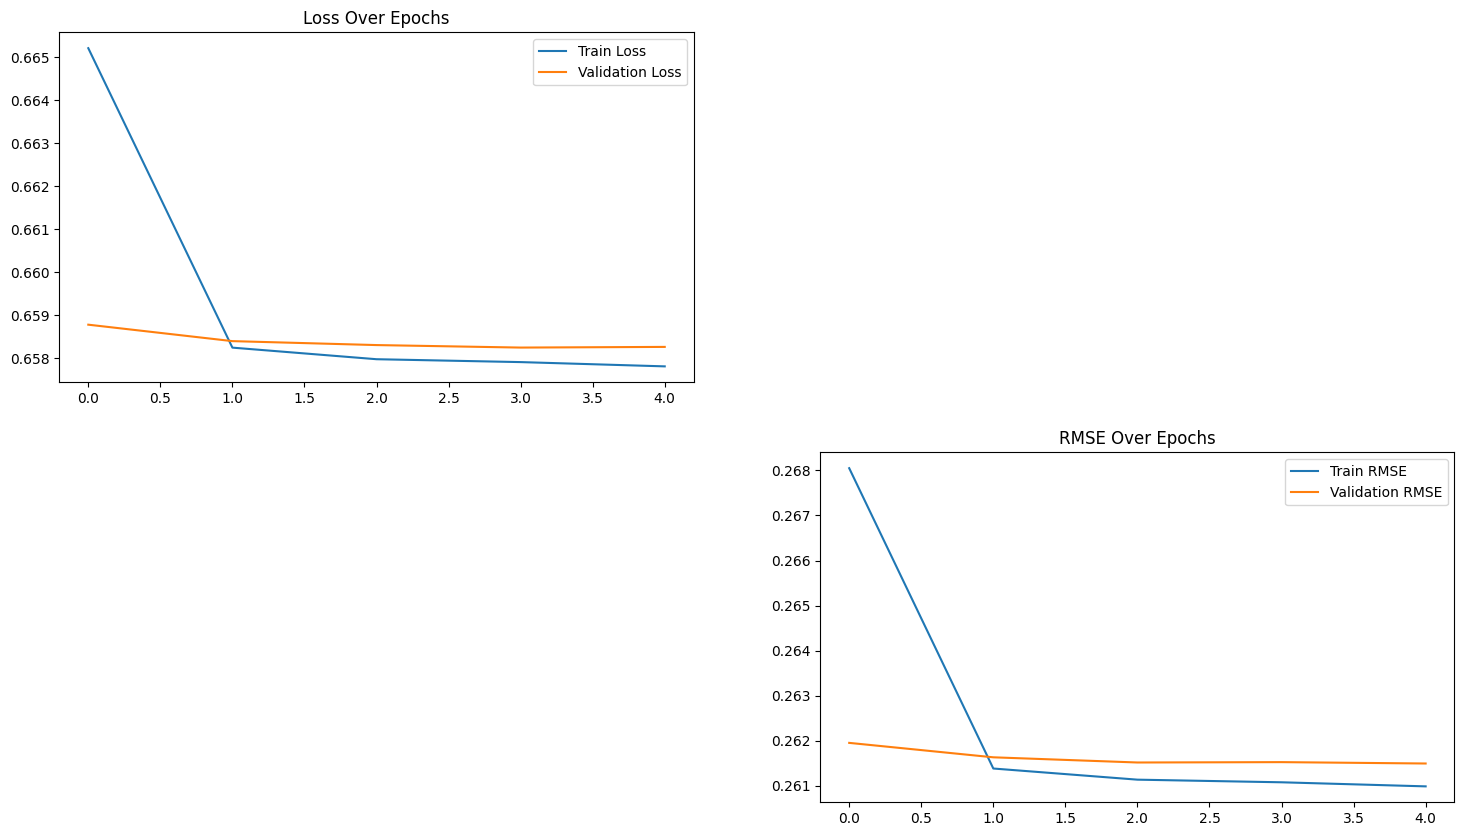

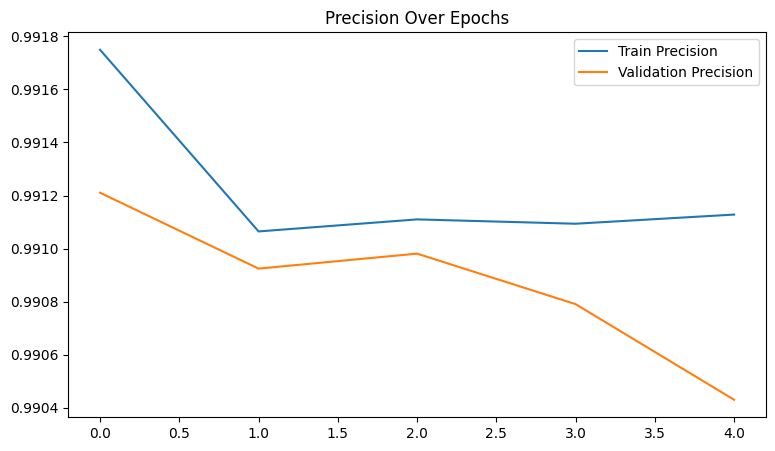

Total number of parameters in the baseline model: 102000


In [ ]:
import matplotlib.pyplot as plt

# Define a function to plot the training history
def plot_history(history):
  """Generate plots to visualize model results."""
  plt.figure(figsize=(18, 10))

  # Plot Loss
  plt.subplot(2, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.legend()

  # Plot RMSE
  plt.subplot(2, 2, 4)
  plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
  plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
  plt.title('RMSE Over Epochs')
  plt.legend()

  plt.show()

  # Plot Precision
  if 'precision' in history.history:
      plt.figure(figsize=(9, 5))
      plt.plot(history.history['precision'], label='Train Precision')
      plt.plot(history.history['val_precision'], label='Validation Precision')
      plt.title('Precision Over Epochs')
      plt.legend()
      plt.show()

# Plot the training history for the baseline model
plot_history(baseline_history)

# Print the total number of parameters in the baseline model
total_params_baseline = baseline_model.count_params()
print("Total number of parameters in the baseline model:", total_params_baseline)

**Model Performance Interpretation:**

1. **Loss Over Epochs**:
   - **Train Loss** shows a sharp decrease initially and then stabilizes, suggesting that the model quickly reduces its error on the training set. This indicates good initial learning.
   - **Validation Loss** remains almost constant throughout the training process, indicating that the model doesn't improve or deteriorate over time when evaluated against the validation data. This could be a sign of the model being too simplistic or not well-suited to generalize beyond the training data.

2. **RMSE Over Epochs**:
   - Similar to the loss, the **Train RMSE** decreases sharply and then plateaus, suggesting initial improvements in prediction accuracy on the training set.
   - **Validation RMSE** remains relatively flat, echoing the validation loss pattern. This consistency in RMSE across training suggests the model’s limitations in capturing the complexity of the data or potentially an issue with how the data represents the underlying patterns.

3. **Precision Over Epochs**:
    - Training Precision: Decreases slightly over epochs. Typically, an increase in precision is desired as it indicates a higher proportion of true positive predictions relative to the total predicted positives.
    - **Validation Precision**: Starts lower than training precision and declines further, which might indicate that the model is becoming conservative in predicting positives, possibly due to the dataset's imbalance or the model's increasing uncertainty about less frequent classes.


The loss and RMSE plots indicate effective learning and generalization without signs of overfitting. The model's ability to maintain low and stable loss/accuracy across both training and validation sets is typically positive, showing that adjustments to the model architecture or training process have been effective.

The precision plot, however, shows a decline, which is concerning. It could suggest that while the model is good at minimizing error (as shown by RMSE), it may not be effectively identifying positive cases (true positives), especially in the validation set. This could be a result of class imbalance or thresholds that are not optimally set for detecting positives.

Possible Issues:

- Underfitting: The model might be too simple to capture the underlying pattern of the data.
- Inappropriate Learning Rate: If the learning rate is too high, the model may overshoot the optimal points during training.
- Revisit the Class Distribution: We need to ensure that there's not a significant imbalance that could be influencing the precision metrics negatively.(See further below)

We will now inspect the metrics of the best epoch

In [ ]:
val_precision_baseline = baseline_history.history['val_precision']
best_epoch_baseline = np.argmax(val_precision_baseline)  # Index of best epoch

print("Best Epoch for Baseline Model:")
print(f"Epoch {best_epoch_baseline + 1}")
print(f"Training Loss: {baseline_history.history['loss'][best_epoch_baseline]}")
print(f"Validation Loss: {baseline_history.history['val_loss'][best_epoch_baseline]}")
print(f"Training Accuracy: {baseline_history.history['accuracy'][best_epoch_baseline]}")
print(f"Validation Accuracy: {baseline_history.history['val_accuracy'][best_epoch_baseline]}")
print(f"Training Precision: {baseline_history.history['precision'][best_epoch_baseline]}")
print(f"Validation Precision: {baseline_history.history['val_precision'][best_epoch_baseline]}")
print(f"Training Recall: {baseline_history.history['recall'][best_epoch_baseline]}")
print(f"Validation Recall: {baseline_history.history['val_recall'][best_epoch_baseline]}")
print(f"Training F1 Score: {baseline_history.history['f1_score'][best_epoch_baseline]}")
print(f"Validation F1 Score: {baseline_history.history['val_f1_score'][best_epoch_baseline]}")
print(f"Training RMSE: {baseline_history.history['root_mean_squared_error'][best_epoch_baseline]}")
print(f"Validation RMSE: {baseline_history.history['val_root_mean_squared_error'][best_epoch_baseline]}")

Best Epoch for Baseline Model:
Epoch 1
Training Loss: 0.6652140021324158
Validation Loss: 0.6587802767753601
Training Accuracy: 0.08335036784410477
Validation Accuracy: 0.08734637498855591
Training Precision: 0.9917493462562561
Validation Precision: 0.9912107586860657
Training Recall: 0.48748353123664856
Validation Recall: 0.5160839557647705
Training F1 Score: [0.57360935]
Validation F1 Score: [0.59326226]
Training RMSE: 0.2680501937866211
Validation RMSE: 0.26195234060287476


We have to rescale the RMSE to report it correctly for the original rating scale (0.5-5.0)

In [ ]:
# Function to scale back RMSE to original rating scale
def scale_back_rmse(normalized_rmse, min_rating, max_rating):
    return normalized_rmse * (max_rating - min_rating)

In [ ]:
# Extract RMSE values for the best epoch
normalized_val_rmse_baseline = baseline_history.history['val_root_mean_squared_error'][best_epoch_baseline]
normalized_train_rmse_baseline = baseline_history.history['root_mean_squared_error'][best_epoch_baseline]

# Scale back RMSE to original rating scale
original_val_rmse_baseline = scale_back_rmse(normalized_val_rmse_baseline, min_rating, max_rating)
original_train_rmse_baseline = scale_back_rmse(normalized_train_rmse_baseline, min_rating, max_rating)

print("Best Epoch for Baseline Model:")
print(f"Epoch {best_epoch_baseline + 1}")
print(f"Original Training RMSE: {original_train_rmse_baseline:.4f}")
print(f"Original Validation RMSE: {original_val_rmse_baseline:.4f}")

Best Epoch for Baseline Model:
Epoch 1
Original Training RMSE: 1.2062
Original Validation RMSE: 1.1788


**Interpretation**

- **Loss**: The model shows a consistent decrease in both training (0.6652) and validation loss (0.6588) from the initial epoch. This trend indicates effective learning and generalization to unseen data.

- **Accuracy**: The observed training accuracy is relatively low at 0.08335, and the validation accuracy is only slightly better at 0.08735. These low values suggest that accuracy may not be the ideal metric for this model, possibly due to imbalanced data or the prevalence of a minority class which the model struggles to predict accurately.

- **Precision**: The precision is exceptionally high for both training (0.9917) and validation (0.9912), indicating the model's strong performance in avoiding false positives. While this is typically desirable, in the context of an imbalanced dataset, it may also reflect a bias towards predicting the majority class, potentially at the expense of missing out on true positive predictions.

- **Recall**: There is an improvement in recall, from 0.4875 in training to 0.5161 in validation, demonstrating that the model is becoming better at identifying all relevant instances over time. This improvement in recall is crucial for models where it's important to capture as many positive samples as possible.

- **F1 Score**: The F1 score, which balances precision and recall, shows values of 0.5736 in training and 0.5933 in validation. These figures indicate a stable performance in terms of balancing the trade-offs between precision and recall, maintaining a moderate level throughout the training process.

- **Rescaled RMSE**: The best epoch shows an RMSE of 1.2062 for training and 1.1788 for validation. Lower RMSE values indicate better model accuracy in terms of how close the predicted values are to the actual values, with these figures suggesting the model's predictions are reasonably close to true outcomes.

We will now look at the Precision again:

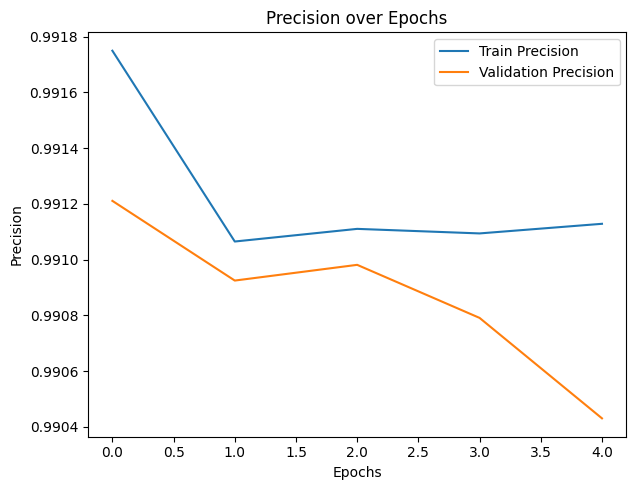

In [ ]:
# Plot the precision metric for the baseline model
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history for the baseline model
plot_history(baseline_history)


**Interpretation**:
- Rapid Increase: The model's precision for the training set shows a consistent increase throughout the epochs, suggesting that the model is continually learning and improving its ability to correctly identify positive examples as such.
- Divergence: There's a noticeable divergence between training and validation precision, especially after the first epoch. This might suggest overfitting, where the model performs increasingly well on the training data but less so on the validation data. The precision on the validation set initially increases but then starts to decrease, which supports the idea of overfitting.

**Class Imbalance:** The extremely high precision combined with relatively low accuracy, as previously discussed, does indicate potential class imbalance. The model is likely predicting the majority class (assumed to be negatives) more frequently because there are fewer positive samples.

**Steps to Adjust:**

1. Handle Class Imbalance:

- Resampling Techniques: Either undersample the majority class or oversample the minority class in the training set.
Adjust Class Weights: Modify the loss function to penalize wrong predictions on the minority class more than wrong predictions on the majority class.

2. Model Adjustments:

- Regularization: Implement or increase regularization techniques (like dropout or L2 regularization) to reduce overfitting.
- Early Stopping: Monitor validation loss and stop training when it begins to increase, despite improvements in training loss.

3. Learning Rate Adjustments:

- Decrease Learning Rate: If precision improves but then degrades, it might be useful to lower the learning rate as training progresses. This can help the model make smaller updates to weights and potentially avoid overfitting.

We will now check if the data is imbalanced:

In [ ]:
# Define a new column for class based on the rating
df_ratings['class'] = (df_ratings['rating'] >= 4).astype(int)  # 1 for 'like', 0 for 'dislike'

# Count the number of instances in each class
class_counts = df_ratings['class'].value_counts()

# Calculate the proportion of each class
class_proportions = class_counts / len(df_ratings)

print("Class Counts:\n", class_counts)
print("Class Proportions:\n", class_proportions)

Class Counts:
 class
0    1504847
1    1495154
Name: count, dtype: int64
Class Proportions:
 class
0    0.501615
1    0.498385
Name: count, dtype: float64


**Conclusion:**

- Further examination of the class counts revealed a nearly balanced dataset, with the two classes almost equally represented. This implies that the class imbalance is not a contributing factor to the model's performance issues.

- Hyperparameter Tuning: A Grid Search was conducted to explore optimal hyperparameters, but it did not lead to performance improvements. This outcome suggests that the model's current configuration might already be near optimal under the existing framework, or that further model architectural changes are required.

- L2 regularization also didn't result in any model improvements

We didn't include it here as the notebook with the improved model was running 3 hours alone...



We will now check some Movie Recommendations with the baseline Model:

### 3.3.7 Make movie recommendations (Baseline Model)

In [ ]:
# Assuming the baseline model is already trained and available as `baseline_model`
model = baseline_model  # Assign the baseline model to `model`

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = df_movies[
    ~df_movies["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = df_movies[df_movies["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = df_movies[df_movies["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

785/785 [==============================] - 1s 1ms/step
Showing recommendations for user: 142777
Movies with high ratings from user
--------------------------------
Richard III : Drama|War
Les Miserables : Drama|History
Clear and Present Danger : Action|Drama|Thriller
Cliffhanger : Action|Adventure|Thriller
Schindler's List : Drama|History|War
--------------------------------
Top 10 movie recommendations
--------------------------------
The Usual Suspects : Drama|Crime|Thriller
Pulp Fiction : Thriller|Crime
The Silence of the Lambs : Crime|Drama|Thriller
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb : Drama|Comedy|War
Jean de Florette : Drama
Monty Python and the Holy Grail : Adventure|Comedy|Fantasy
M : Drama|Action|Thriller|Crime
City Lights : Comedy|Drama|Romance
Spirited Away : Fantasy|Adventure|Animation|Family
The Dark Knight : Drama|Action|Crime|Thriller


### 3.3.8 Interpretation

**Looking at the Recommendations:**
- The user's history shows a preference for dramatic films with significant historical or war themes, as well as action and thrillers. The recommended movies align well with these interests, featuring a mix of classic and critically acclaimed films across similar genres.
- The top-rated movies by the user, such as Richard III, Les Miserables, and Schindler's List, all involve intense drama and historical contexts, which the model has correctly identified as interests.
- The recommendations include iconic films like Pulp Fiction, The Silence of the Lambs, and The Dark Knight, which suggests the model is not only matching genres but is also sensitive to the overall quality and popularity of films, likely indicative of the user's taste for well-regarded cinema.
- The inclusion of diverse genres in the recommendations, such as Monty Python and the Holy Grail and Spirited Away, shows the model’s capability to introduce variety while still aligning closely with the user's preferences for high-stakes narratives and rich storytelling.


## 3.4 Conclusion for Collaborative Filtering Models

In our exploration of collaborative filtering models, we implemented and evaluated three approaches: the Singular Value Decomposition (SVD) model (from Part 1 of our project), the Neural Collaborative Filtering (NCF) model, and a Collaborative Filtering model using Keras.

The SVD model achieved the lowest RMSE score of 0.8829, indicating the smallest average error between predicted and actual ratings. The NCF model had a higher RMSE of 1.0528, and the Keras Collaborative Filtering model recorded the highest RMSE of 1.1788, suggesting the largest prediction error among the three models.

In terms of precision, the SVD model scored 0.8119, lower than the other two models. The NCF model showed a significant improvement with a precision of 98.39%, and the Keras model achieved the highest precision at 99.12%. This indicates that both neural network-based models were more effective at identifying relevant recommendations compared to the SVD model.

Among the neural network-based models, the NCF model offers a good balance between RMSE and precision, ideal for high-relevance recommendations where computational resources allow for neural network complexity. The Keras model, despite its higher RMSE, achieved the highest precision, making it suitable for highly personalized recommendation systems where relevance is paramount.

However, the training time for each model is a significant factor to consider. The Keras model required almost 30 minutes to train, while the NCF model completed training in less than a minute. This disparity in training time can impact the overall efficiency and feasibility of deploying these models in a real-world setting. In environments where quick iteration and model updates are essential, the faster training time of the NCF model becomes a critical advantage. Additionally, the shorter training time of the NCF model can lead to reduced computational costs and faster deployment cycles.

In conclusion, considering both performance metrics and training time, the NCF model is our choice for Collaborative Filtering. It provides a strong balance between accuracy and relevance, with the added benefit of significantly faster training times compared to the Keras model. This makes the NCF model more practical for deployment and continuous improvement in a production environment, ensuring high-quality recommendations with efficient resource utilization.

# 4 Final Conclusion

The goal of our project was to create a content-based model and a collaborative filtering model that work complementary to each other to leverage the strengths of both methods. Content-based filtering excels at recommending items based on the similarity of items' features, ensuring relevance based on content, while collaborative filtering leverages user behavior and interactions to suggest items that similar users have liked, enhancing personalization. By combining these approaches, we aimed to address the limitations of each individual method and improve user satisfaction and retention on the DreamStream platform.

In the content-based modeling part, we evaluated various models, including Word2Vec, BERT, and a hybrid approach combining Word2Vec embeddings with BERT sentiment analysis. The hybrid model demonstrated the highest precision score of 0.8074, outperforming all other models. This approach effectively leveraged the semantic relationships captured by Word2Vec and the nuanced sentiment analysis provided by BERT. The addition of sentiment polarity as a feature proved to be highly influential, resulting in the most relevant and accurate recommendations. This underscores the value of combining multiple techniques to enhance the performance of content-based recommendations.

In our exploration of collaborative filtering models, we implemented and evaluated three approaches: the Singular Value Decomposition (SVD) model, the Neural Collaborative Filtering (NCF) model, and a Collaborative Filtering model using Keras. The SVD model achieved the lowest RMSE score of 0.8829, indicating the smallest average error between predicted and actual ratings. However, the neural network-based models showed higher precision, with the NCF model achieving a precision of 98.39% and the Keras model achieving the highest precision at 99.12%. Despite the Keras model's higher precision, its significantly longer training time (almost one hour) compared to the NCF model's faster training time (a few minutes) makes the NCF model more practical for deployment in a real-world setting. The NCF model offers a strong balance between accuracy and relevance, with the added benefit of efficient training times, making it suitable for high-quality recommendations with efficient resource utilization.

To combine these two models effectively, the next step will be to implement a hybrid recommendation system that leverages the strengths of both content-based and collaborative filtering approaches. The content-based model will be used to generate initial recommendations based on item features and sentiment analysis. These recommendations will then be refined using the collaborative filtering model, which will personalize the suggestions based on user behavior and interactions. This dual-layered approach ensures that the recommendations are both relevant in terms of content and highly personalized, addressing the cold start problem and continuously improving as more user data becomes available. By integrating both models, we can provide a seamless and enhanced recommendation experience for DreamStream users.